In [1]:
# ====================== Path Manager (portable paths) ======================
import os
from pathlib import Path

def _in_colab() -> bool:
    try:
        import google.colab  # noqa: F401
        return True
    except Exception:
        return False

IN_COLAB = _in_colab()

def _find_repo_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(5):
        if (cur / ".git").exists() or (cur / "README.md").exists():
            return cur
        cur = cur.parent
    return start.resolve()

REPO_ROOT = _find_repo_root(Path.cwd())

DATA_DIR = Path(os.getenv("DATA_DIR", REPO_ROOT / "data"))
OUTPUT_DIR = Path(os.getenv("OUTPUT_DIR", REPO_ROOT / "outputs"))
MODELS_DIR = Path(os.getenv("MODELS_DIR", REPO_ROOT / "models"))
for d in [DATA_DIR, OUTPUT_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

def p(*parts) -> Path:
    return REPO_ROOT.joinpath(*parts)

def data_path(*parts) -> Path:
    return DATA_DIR.joinpath(*parts)

def out_path(*parts) -> Path:
    return OUTPUT_DIR.joinpath(*parts)

def model_path(*parts) -> Path:
    return MODELS_DIR.joinpath(*parts)

MOUNT_DRIVE = bool(int(os.getenv("MOUNT_DRIVE", "0")))  # set to 1 to mount in Colab
if IN_COLAB and MOUNT_DRIVE:
    from google.colab import drive
    drive.mount(str(p('drive')), force_remount=False)

# Advanced DL Project - Sentiment Classification

#Imports & Globals

In [10]:
from google.colab import drive
drive.mount(str(p('drive')));

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
req = str(data_path('Colab Notebooks', 'requirements.txt'))
!pip install -r "$req"

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/data/Colab Notebooks/requirements.txt'


In [4]:
pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 119.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.2
    Uninstalling transformers-4.55.2:
      Successfully uninstalled transformers-4.55.2


In [5]:
!pip install -U "transformers>=4.44" "datasets>=2.19" "accelerate>=0.33"

In [6]:
# Install ONNX + make sure versions are compatible
!pip install -U "onnx>=1.16,<1.17" "onnxruntime>=1.17,<2" "optimum>=1.19,<2" "transformers>=4.42,<5"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.8/425.8 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00


In [7]:
pip install wordsegment wordfreq wordninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=33e3e07930da1150f5c5a6ce547e47bd25c12ec20662da1f8cd44ee8e7432263
  Stored in directory: /root/.cache/pip/wheels/6e/31/92/f12667e4dd102e546832a02f41feca39ae916889006517e595
Successfully built wordninja


In [8]:
# ============================ Standard Library ============================
import os
import json
import math
import random
import re
import shutil
import html
import warnings
import gc
from dataclasses import dataclass
from typing import Any, Dict, List
from functools import lru_cache
from collections import Counter
from inspect import signature

# =============================== Third-Party ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ftfy
import wordsegment
from datasets import Dataset
from tqdm.auto import tqdm
import optuna
import wandb

# ================================ PyTorch =================================
import torch
import torch.nn as nn
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.nn.utils import prune

# ======================= Hugging Face Transformers ========================
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    get_linear_schedule_with_warmup,
)
from transformers.utils import logging as hf_logging

# ============================== Scikit-learn ==============================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    auc,
)

# ============================== Google Colab ==============================
from google.colab import drive

# ============================== Warnings Filter ===========================
# Suppress deprecation warning for torch.ao.quantization (if appears)
warnings.filterwarnings("ignore", message=".*torch.ao.quantization is deprecated.*")

ModuleNotFoundError: No module named 'optuna'

In [ ]:
LABEL2ID = {"Negative": 0, "Neutral": 1, "Positive": 2}
ID2LABEL = {v:k for k,v in LABEL2ID.items()}

#Part A - EDA

## Exploration
We'll explore the data by showing statistics, data types, and Number of unique words, distribution

In addition, we'll plot some visualization to better understend the data

In [ ]:
# Basic data sanity: nulls & duplicates
def data_quality_report(df, text_col='OriginalTweet', label_col='Sentiment'):
    """Print simple quality stats: nulls, duplicates."""
    n = len(df)
    null_text = df[text_col].isna().sum()
    null_label = df[label_col].isna().sum()
    dup_text = df[text_col].duplicated().sum()
    print(f"Rows: {n}")
    print(f"Null {text_col}: {null_text}  |  Null {label_col}: {null_label}")
    print(f"Exact-duplicate {text_col}: {dup_text}")

# 3) Basic data sanity: nulls & duplicates
def data_quality_report(df, text_col='OriginalTweet', label_col='Sentiment'):
    """Print simple quality stats: nulls, duplicates."""
    n = len(df)
    null_text = df[text_col].isna().sum()
    null_label = df[label_col].isna().sum()
    dup_text = df[text_col].duplicated().sum()
    print(f"Rows: {n}")
    print(f"Null {text_col}: {null_text}  |  Null {label_col}: {null_label}")
    print(f"Exact-duplicate {text_col}: {dup_text}")

# 4) Label-wise proportions for hashtags / mentions / URLs
def add_meta_flags(df, text_col='OriginalTweet'):
    """Add boolean columns: has_hashtag / has_mention / has_url."""
    x = df.copy()
    s = x[text_col].astype(str)
    x['has_hashtag'] = s.str.contains(r'#\w+', case=False, regex=True)
    x['has_mention'] = s.str.contains(r'@\w+', regex=True)
    x['has_url']     = s.str.contains(r'http[s]?://', regex=True)
    return x

def proportions_by_label(df, label_col='Sentiment'):
    """Show share of rows with hashtags/mentions/urls per label."""
    cols = ['has_hashtag','has_mention','has_url']
    if not set(cols).issubset(df.columns):
        print("Run add_meta_flags(df) first to create indicator columns.")
        return
    out = (df.groupby(label_col)[cols]
             .mean()
             .rename(columns=lambda c: c.replace('has_', 'share_'))
             .reset_index())
    print(out.to_string(index=False))

def ensure_text_length(df: pd.DataFrame, text_col: str = 'OriginalTweet', length_col: str = 'text_length') -> pd.DataFrame:
    """Ensure a length column exists: count whitespace-separated tokens (words)."""
    if length_col not in df.columns:
        df[length_col] = df[text_col].astype(str).apply(lambda s: len(s.split()))
    return df

def plot_label_distribution(df: pd.DataFrame, label_col: str = 'Sentiment') -> None:
    """Simple bar chart of label distribution."""
    counts = df[label_col].value_counts()
    plt.figure(figsize=(7, 5))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title('Label distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

def plot_length_hist(df):
    filter = 1000
    plt.figure(figsize=(8, 6))
    sns.histplot(df[df['text_length'] < filter], x='text_length',
                 hue='Sentiment', bins=50, kde=True)
    # Add a vertical line at 50
    plt.axvline(x=50, color='red', linestyle='--', label='Max Length Encoding (40)')
    plt.title('Text Length Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    # Get unique labels dynamically from the dataframe
    unique_labels = list(df['Sentiment'].unique())
    unique_labels.append('50 words')  # Add the padding/length marker
    plt.legend(title='Legend', labels=unique_labels)
    plt.show()

def plot_length_box_by_label(df, label_col='Sentiment', length_col='text_length'):
    """Boxplot of text length by label."""
    plt.figure(figsize=(8, 5))
    # Using plain matplotlib to keep dependencies aligned
    labels = df[label_col].unique()
    data = [df.loc[df[label_col]==lab, length_col].dropna().astype(int) for lab in labels]
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.title('Text length by label')
    plt.ylabel('Number of words')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

def extract_hashtags(text: str):
    """Extract hashtags as lowercase tokens (with '#')."""
    return re.findall(r"#\w+", str(text).lower())

def add_hashtags_column(df: pd.DataFrame, text_col: str = 'OriginalTweet') -> pd.DataFrame:
    """Add a 'hashtags' list column."""
    df = df.copy()
    df['hashtags'] = df[text_col].apply(extract_hashtags)
    return df

def plot_top_hashtags(df: pd.DataFrame, topn: int = 30) -> None:
    """Bar chart of the top-N hashtags."""
    all_ht = [h for hs in df.get('hashtags', []) for h in (hs or [])]
    if not all_ht:
        print("No hashtags found. Run add_hashtags_column first.")
        return
    c = Counter(all_ht).most_common(topn)
    labels, vals = zip(*c)
    plt.figure(figsize=(10, 6))
    plt.bar(labels, vals)
    plt.title(f'Top {topn} hashtags')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def top_ngrams(series: pd.Series, ngram_range=(1, 1), topn: int = 20) -> pd.DataFrame:
    """Compute top-N ngrams on a text series (expects whitespace tokenization)."""
    vec = CountVectorizer(ngram_range=ngram_range, lowercase=False, tokenizer=lambda s: s.split())
    X = vec.fit_transform(series.fillna("").astype(str))
    vocab = vec.get_feature_names_out()
    counts = np.asarray(X.sum(axis=0)).ravel()
    order = np.argsort(-counts)[:topn]
    return pd.DataFrame({'ngram': vocab[order], 'count': counts[order]})

def top_ngrams_by_label(df: pd.DataFrame, text_col: str, label_col: str, ngram_range=(1, 1), topn: int = 20) -> pd.DataFrame:
    """Compute top-N ngrams per label."""
    rows = []
    for label, g in df.groupby(label_col):
        tdf = top_ngrams(g[text_col], ngram_range=ngram_range, topn=topn)
        tdf['label'] = label
        rows.append(tdf)
    return pd.concat(rows, ignore_index=True)

def plot_top_ngrams(df_ngrams: pd.DataFrame, topn: int = 20, title: str = 'Top n-grams') -> None:
    """Plot n-grams; if 'label' column exists, create small multiples per label."""
    g = df_ngrams.copy()
    if 'label' in g.columns:
        labels = list(g['label'].unique())
        ncols = min(3, len(labels))
        nrows = int(np.ceil(len(labels) / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows), squeeze=False)

        for i, lab in enumerate(labels):
            ax = axes[i // ncols, i % ncols]
            gi = g[g['label'] == lab].nlargest(topn, 'count')
            ax.bar(gi['ngram'], gi['count'])
            ax.set_title(f"{title} - {lab}")
            ax.set_xticks(range(len(gi)))
            ax.set_xticklabels(gi['ngram'], rotation=90)

        # delete empty subplots (if any)
        axes_flat = axes.ravel()
        for j in range(len(labels), len(axes_flat)):
            fig.delaxes(axes_flat[j])

        plt.tight_layout()
        plt.show()
    else:
        top = g.nlargest(topn, 'count')
        plt.figure(figsize=(10, 6))
        plt.bar(top['ngram'], top['count'])
        plt.title(title)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

def class_imbalance_report(df, label_col):
    # Print class distribution and ratio for imbalance check
    counts = df[label_col].value_counts(normalize=False)
    perc   = df[label_col].value_counts(normalize=True).mul(100).round(2)
    rep = pd.DataFrame({'count': counts, 'percent': perc})
    return rep

In [ ]:
# Read CSV file
df = pd.read_csv(str(data_path('Colab Notebooks', 'Corona_NLP_train.csv')), encoding='latin1')

# Keep only the columns you need
df = df[['OriginalTweet', 'Sentiment']]

# Remove rows with missing values in those columns
df = df.dropna(subset=['OriginalTweet', 'Sentiment']).reset_index(drop=True)

# Preview the first rows
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
num_row = 700
print(df['Sentiment'].iloc[num_row])
print(df['OriginalTweet'].iloc[num_row])

Negative




https://t.co/fHv3g5v7Pi


In [ ]:
df['text_length'] = df['OriginalTweet'].apply(lambda x:len(x.split()))
print(df['text_length'].describe())

count    41157.000000
mean        30.500304
std         11.591172
min          1.000000
25%         21.000000
50%         32.000000
75%         40.000000
max         64.000000
Name: text_length, dtype: float64


In [ ]:
data_quality_report(df)
df_meta = add_meta_flags(df)
proportions_by_label(df_meta)

Rows: 41157
Null OriginalTweet: 0  |  Null Sentiment: 0
Exact-duplicate OriginalTweet: 0
         Sentiment  share_hashtag  share_mention  share_url
Extremely Negative       0.556650       0.220580   0.392082
Extremely Positive       0.567482       0.258907   0.452446
          Negative       0.565494       0.241807   0.458606
           Neutral       0.617270       0.220407   0.600545
          Positive       0.573455       0.245053   0.481439


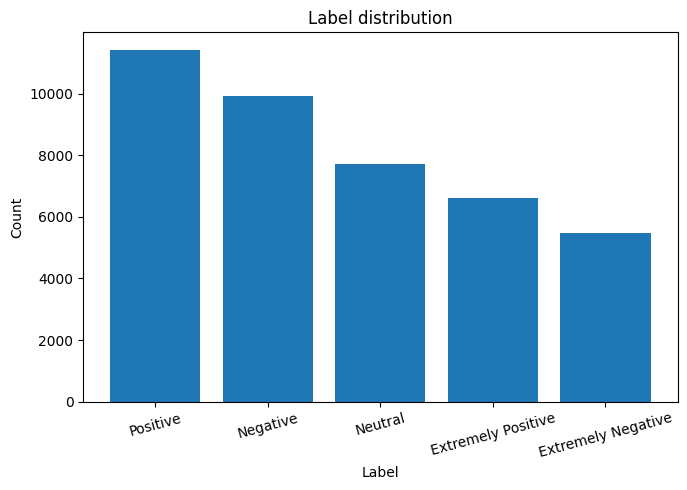

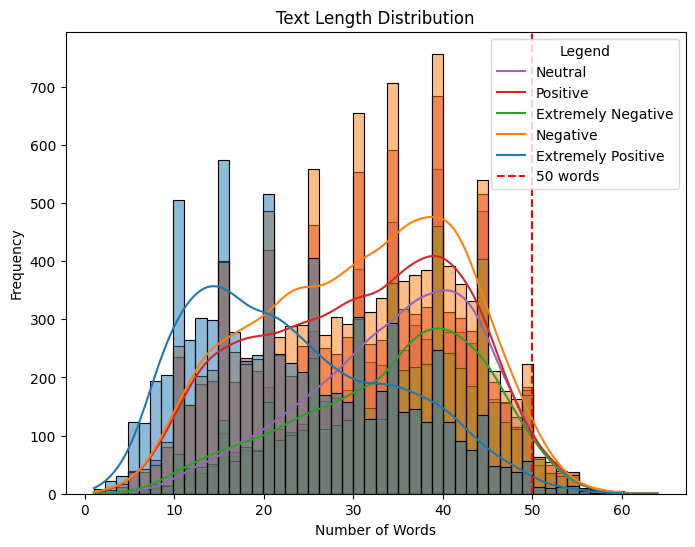

/tmp/ipython-input-4266940565.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


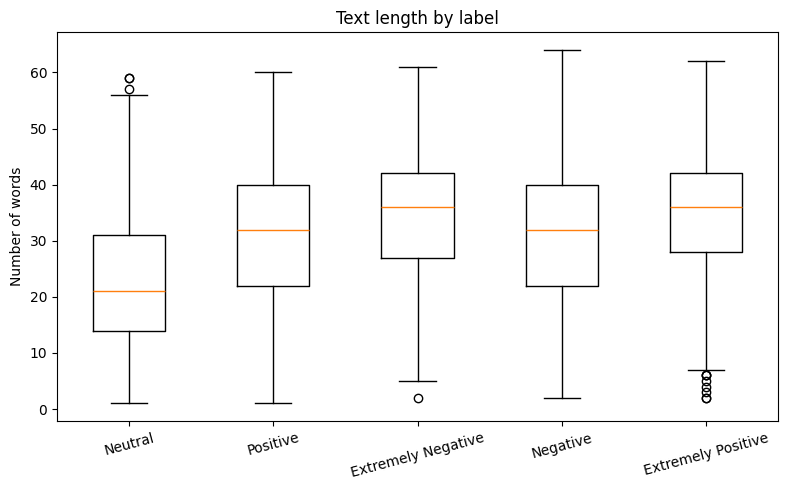

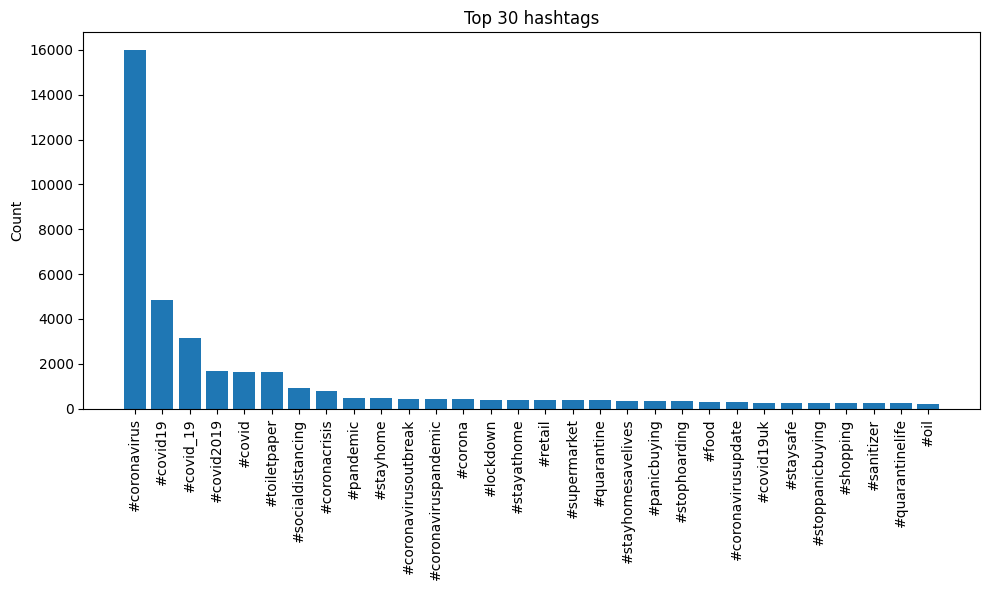

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extr

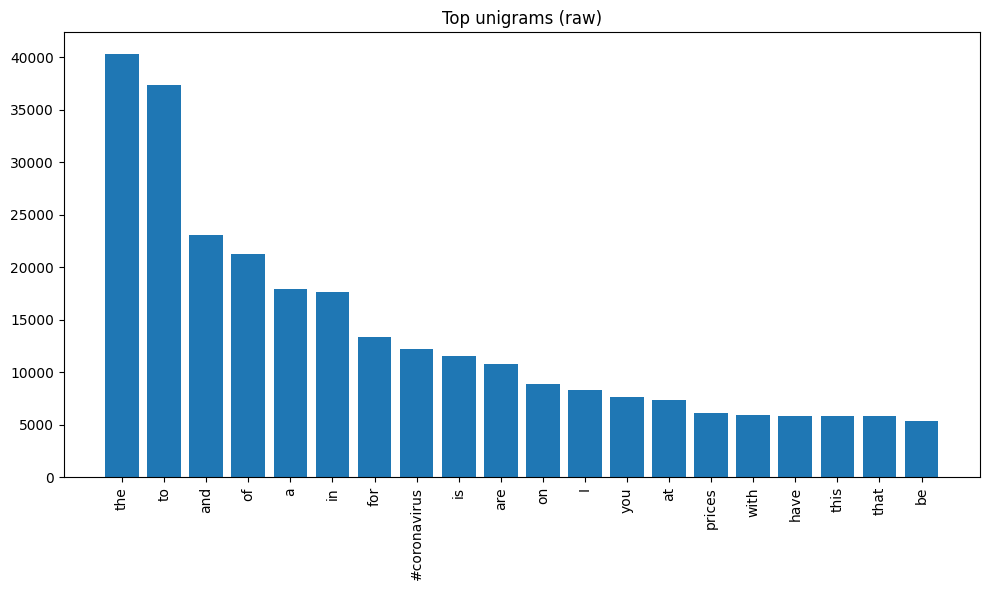

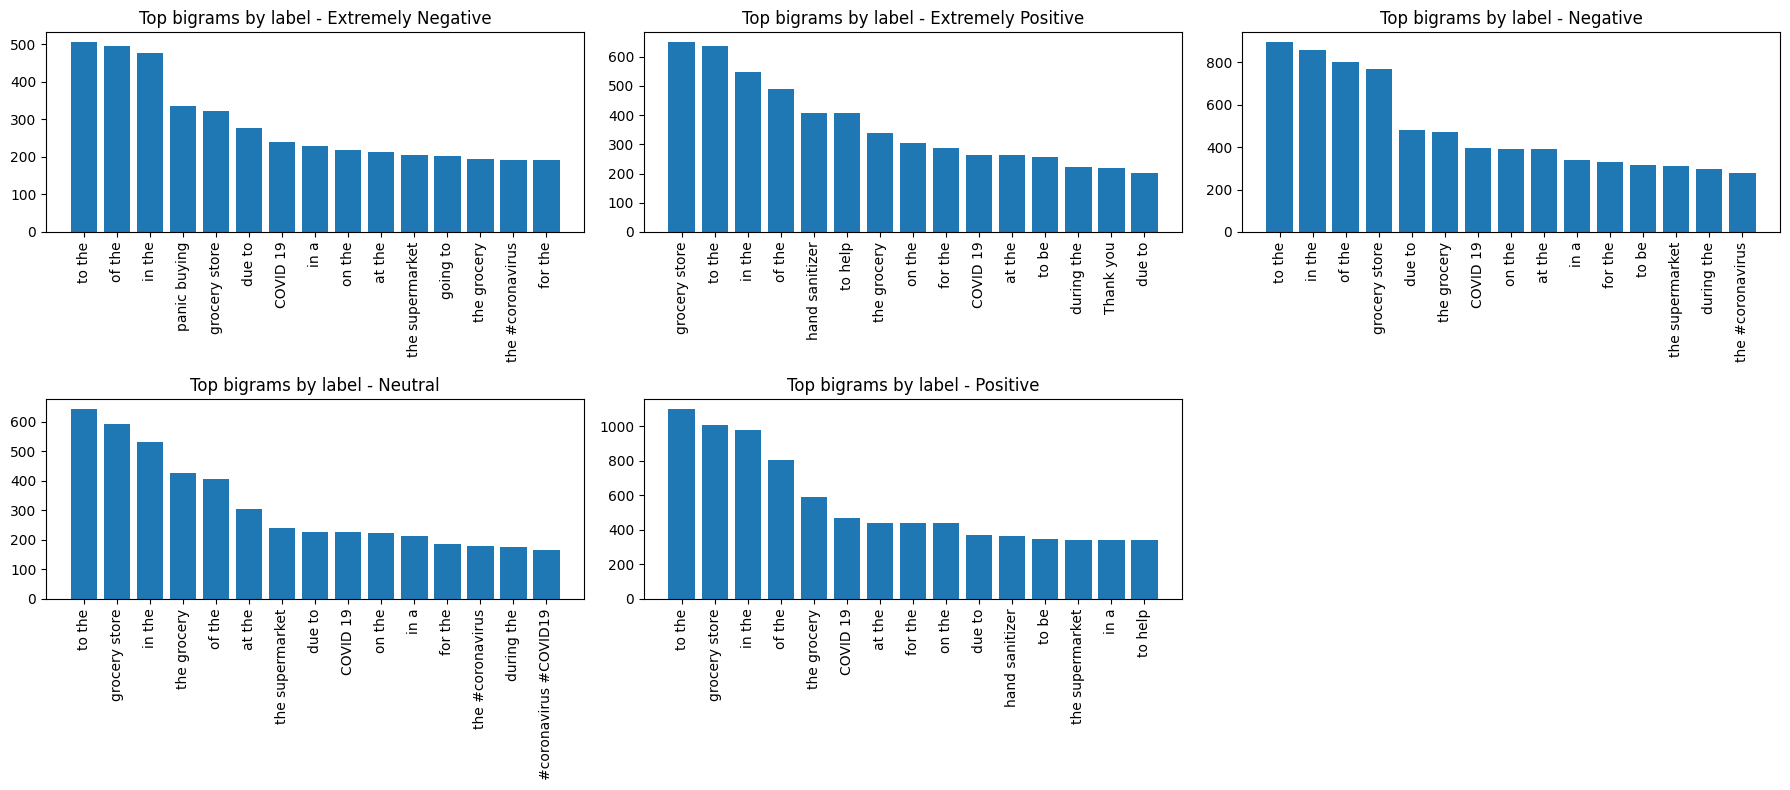

In [ ]:
plot_label_distribution(df, 'Sentiment')
plot_length_hist(df)
plot_length_box_by_label(df)

df = add_hashtags_column(df, 'OriginalTweet')
plot_top_hashtags(df, topn=30)

uni_all = top_ngrams(df['OriginalTweet'].astype(str), (1,1), topn=30)
bigrams_by_label = top_ngrams_by_label(df, 'OriginalTweet', 'Sentiment', (2,2), topn=15)
plot_top_ngrams(uni_all, topn=20, title='Top unigrams (raw)')
plot_top_ngrams(bigrams_by_label, topn=15, title='Top bigrams by label')

## Pre-processing
Two pipelines:
- **Twitter Sentiments** (minimal, `@USER`/`HTTPURL`, keep `#hashtag`, keep emojis, cased)
- **Generic** (gentle: lowercasing, url→`url`, user→`user`, remove `#`)

In [ ]:
prcessed_df = df.copy()

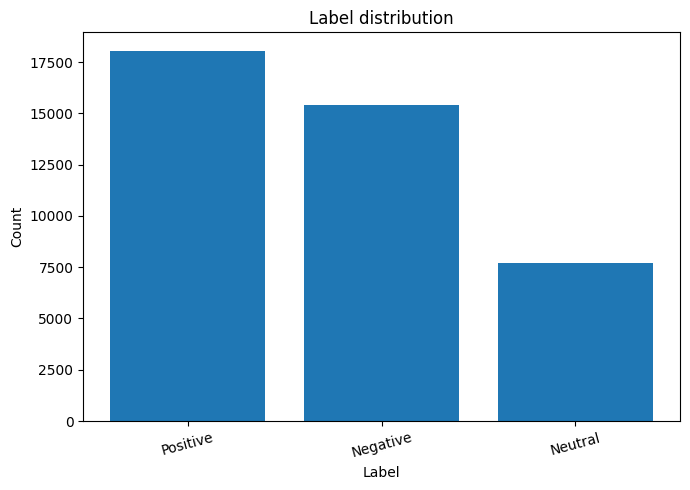

,count,percent
Sentiment,,
Positive,18046,43.85
Negative,15398,37.41
Neutral,7713,18.74


In [ ]:
# Convert to 3 classes
prcessed_df['Sentiment'] = prcessed_df['Sentiment'].replace({
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative'
})
plot_label_distribution(prcessed_df, 'Sentiment')
class_imbalance_report(prcessed_df, 'Sentiment')

In [ ]:
_URL_RE  = re.compile(r"https?://\S+")
_USER_RE = re.compile(r"@\w+")

def preprocess_twitter_for_cardiff(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.strip()
    out = []
    for tok in s.split():
        if tok.startswith("@") and len(tok) > 1:
            out.append("@USER")
        elif tok.startswith("http"):
            out.append("HTTPURL")
        else:
            out.append(tok)
    return " ".join(out)

In [ ]:
# --- Step 1: Read the CSV file robustly ---
# Using encoding='utf-8' with encoding_errors='ignore' is the key fix.
try:
    df = pd.read_csv(
        str(data_path('Colab Notebooks', 'Corona_NLP_train.csv')),
        encoding='utf-8',
        encoding_errors='ignore'
    )
except FileNotFoundError:
    print("File not found. Please ensure the path is correct and Drive is mounted.")
    # Create a dummy dataframe to allow the rest of the script to run for demonstration
    df = pd.DataFrame({'OriginalTweet': ["Test tweet in english", "????? ????? ??????"]})


# --- Step 2: The Final, Improved Preprocessing Functions ---

# --- Regexes and Constants ---
_URL_RE   = re.compile(r"https?://\S+|www\.\S+")
_USER_RE  = re.compile(r"@\w+")
_HASH_RE  = re.compile(r"#(\w+)")
COVID_RE  = re.compile(r'(?i)(?<!\w)#?covid(?:[\-\u2013\u2014_ ]?19)?(?![\w\d])')
REPEAT_RE = re.compile(r'(.)\1{2,}')
# This regex removes only a specific list of symbols, preserving letters in all languages.
_PUNCT_REMOVE_RE = re.compile(r'[=\+\*\^%<>|~`\[\]\{\}\$\&]')

# Dictionaries for the generic model's hashtag strategy
SPECIAL_HASHTAGS = {
    "toiletpaper": "toilet paper", "panicbuying": "panic buying",
    "socialdistancing": "social distancing", "newyork": "new york",
    "dunnypaper": "toilet paper", "stayhome": "stay home", "stayathome": "stay home"
}
KEEP_SINGLE = {"lockdown", "coronavirus", "virus", "panic", "pandemic", "crisis"}

# --- Helper Functions ---
def normalize_repeats(s: str, max_rep: int = 2) -> str:
    return REPEAT_RE.sub(lambda m: m.group(1) * max_rep, s)

def remove_consecutive_duplicates(s: str) -> str:
    words = s.split()
    if not words: return ""
    result = [words[0]]
    for i in range(1, len(words)):
        if words[i] != words[i-1]:
            result.append(words[i])
    return " ".join(result)

@lru_cache(maxsize=200_000)
def _segment_hashtag(payload: str) -> str:
    if not hasattr(_segment_hashtag, 'loaded'):
        wordsegment.load()
        _segment_hashtag.loaded = True
    return " ".join(wordsegment.segment(payload))

def _handle_hashtag_generic(tag: str) -> str:
    t = tag.lower()
    if t in SPECIAL_HASHTAGS: return SPECIAL_HASHTAGS[t]
    if t in KEEP_SINGLE: return t
    if t.startswith("covid") or t.startswith("corona"): return "covid"
    return _segment_hashtag(t)

# --- Main Unified Preprocessing Function ---
def preprocess_final_v2(text: str, is_twitter_model: bool) -> str:
    if not isinstance(text, str):
        return ""

    text = ftfy.fix_text(text)
    text = html.unescape(text).strip()

    if is_twitter_model:
        text = _URL_RE.sub("HTTPURL", text)
        text = _USER_RE.sub("@USER", text)
    else:
        text = _URL_RE.sub("url", text)
        text = _USER_RE.sub("user", text)
        text = _HASH_RE.sub(lambda m: _handle_hashtag_generic(m.group(1)), text)
        text = COVID_RE.sub("covid", text)
        text = _PUNCT_REMOVE_RE.sub('', text)
        text = text.lower()
        text = normalize_repeats(text, max_rep=2)
        text = remove_consecutive_duplicates(text)

    return re.sub(r"\s+", " ", text).strip()

In [ ]:
# --- Now you can apply this to your dataframe columns ---
prcessed_df['text_cardiff'] = prcessed_df['OriginalTweet'].apply(lambda s: preprocess_final_v2(s, is_twitter_model=True))
prcessed_df['text_generic'] = prcessed_df['OriginalTweet'].apply(lambda s: preprocess_final_v2(s, is_twitter_model=False))

In [ ]:
prcessed_df.head(10)

,OriginalTweet,Sentiment,text_length,hashtags,text_cardiff,text_generic
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,8,[],@USER @USER @USER HTTPURL and HTTPURL and HTTPURL,user url and url and url
1,advice Talk to your neighbours family to excha...,Positive,38,[],advice Talk to your neighbours family to excha...,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,14,[],Coronavirus Australia: Woolworths to give elde...,coronavirus australia: woolworths to give elde...
3,My food stock is not the only one which is emp...,Positive,42,"[#covid19france, #covid_19, #covid19, #coronav...",My food stock is not the only one which is emp...,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Negative,40,"[#covid19, #coronavirus, #coronavirusfrance, #...","Me, ready to go at supermarket during the #COV...","me, ready to go at supermarket during the covi..."
5,As news of the regionÂs first confirmed COVID...,Positive,36,[],As news of the region's first confirmed COVID-...,as news of the region's first confirmed covid ...
6,Cashier at grocery store was sharing his insig...,Positive,28,[#covid_19],Cashier at grocery store was sharing his insig...,cashier at grocery store was sharing his insig...
7,Was at the supermarket today. Didn't buy toile...,Neutral,13,"[#rebel, #toiletpapercrisis, #covid_19]",Was at the supermarket today. Didn't buy toile...,was at the supermarket today. didn't buy toile...
8,Due to COVID-19 our retail store and classroom...,Positive,45,[],Due to COVID-19 our retail store and classroom...,due to covid our retail store and classroom in...
9,"For corona prevention,we should stop to buy th...",Negative,42,"[#govindia, #indiafightscorona]","For corona prevention,we should stop to buy th...","for corona prevention,we should stop to buy th..."


## Data Splitting

In [ ]:
def stratified_split(
    df,
    label_col='Sentiment',
    train_size=0.7,
    val_size=0.1,
    test_size=0.2,
    random_state=42,
    keep_cols=None,
    output_dir=str(p('Colab Notebooks', 'split_data'))
):
    """
    Splits a DataFrame into train, validation, and test sets using stratification.
    If split files already exist in `output_dir`, loads them instead.

    Args:
        df (pd.DataFrame): The input DataFrame (only used if no saved files exist).
        label_col (str): The column to stratify by.
        train_size (float): The proportion for the training set.
        val_size (float): The proportion for the validation set.
        test_size (float): The proportion for the test set.
        random_state (int): Seed for reproducibility.
        keep_cols (list, optional): List of columns to keep in the final DataFrames.
        output_dir (str): Directory to save/load split CSV files.

    Returns:
        tuple: (train_df, val_df, test_df)
    """

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Define file paths
    train_path = os.path.join(output_dir, "train_set.csv")
    val_path   = os.path.join(output_dir, "validation_set.csv")
    test_path  = os.path.join(output_dir, "test_set.csv")

    # --- Case 1: If files already exist, load them ---
    if all(os.path.exists(p) for p in [train_path, val_path, test_path]):
        print("Loading existing split datasets from disk...")
        train_df = pd.read_csv(train_path)
        val_df   = pd.read_csv(val_path)
        test_df  = pd.read_csv(test_path)
        return train_df, val_df, test_df

    # --- Case 2: Otherwise, create new splits ---
    print("No saved splits found. Creating new splits...")

    # Ensure the proportions sum to 1
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6

    # First split: train vs temp (val+test)
    train_df, temp_df = train_test_split(
        df,
        test_size=(val_size + test_size),
        random_state=random_state,
        stratify=df[label_col]
    )

    # Split temp into val and test
    val_ratio_in_temp = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=(1.0 - val_ratio_in_temp),
        random_state=random_state,
        stratify=temp_df[label_col]
    )

    # Filter columns if requested
    if keep_cols:
        final_cols = list(dict.fromkeys([label_col] + keep_cols))
        train_df = train_df[final_cols]
        val_df   = val_df[final_cols]
        test_df  = test_df[final_cols]

    # Reset index
    train_df, val_df, test_df = (
        train_df.reset_index(drop=True),
        val_df.reset_index(drop=True),
        test_df.reset_index(drop=True)
    )

    # Save splits to CSV
    train_df.to_csv(train_path, index=False, encoding='utf-8')
    val_df.to_csv(val_path, index=False, encoding='utf-8')
    test_df.to_csv(test_path, index=False, encoding='utf-8')

    print(f"Datasets saved in '{output_dir}':")
    print(f" - {train_path}")
    print(f" - {val_path}")
    print(f" - {test_path}")

    print(f"Files saved to: {os.path.abspath(output_dir)}")

    return train_df, val_df, test_df

In [ ]:
# ===== Usage Example =====
keep_cols = ["OriginalTweet", "text_cardiff", "text_generic"]

train_df, val_df, test_df = stratified_split(
    df=prcessed_df,  # make sure this DataFrame exists
    label_col="Sentiment",
    train_size=0.7,
    val_size=0.1,
    test_size=0.2,
    random_state=42,
    keep_cols=keep_cols,
    output_dir=str(p('Colab Notebooks', 'split_data'))
)

print("--- Data Split Summary ---")
print(f"Training set:   {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set:       {test_df.shape}")

No saved splits found. Creating new splits...
Datasets saved in '/content/drive/My Drive/Colab Notebooks/split_data':
 - /content/drive/My Drive/Colab Notebooks/split_data/train_set.csv
 - /content/drive/My Drive/Colab Notebooks/split_data/validation_set.csv
 - /content/drive/My Drive/Colab Notebooks/split_data/test_set.csv
Files saved to: /content/drive/My Drive/Colab Notebooks/split_data
--- Data Split Summary ---
Training set:   (28809, 4)
Validation set: (4115, 4)
Test set:       (8233, 4)


In [ ]:
def class_counts(x, col="Sentiment"):
    c = Counter(x[col]); tot = sum(c.values())
    return {k: {"n": v, "p": round(v/tot, 3)} for k, v in sorted(c.items())}

print("Train:", class_counts(train_df))
print("Val  :", class_counts(val_df))
print("Test :", class_counts(test_df))

Train: {'Negative': {'n': 10778, 'p': 0.374}, 'Neutral': {'n': 5399, 'p': 0.187}, 'Positive': {'n': 12632, 'p': 0.438}}
Val  : {'Negative': {'n': 1540, 'p': 0.374}, 'Neutral': {'n': 771, 'p': 0.187}, 'Positive': {'n': 1804, 'p': 0.438}}
Test : {'Negative': {'n': 3080, 'p': 0.374}, 'Neutral': {'n': 1543, 'p': 0.187}, 'Positive': {'n': 3610, 'p': 0.438}}


# Part B - Models Training, Evaluation & Compression

#B.1 - Manually

### Dataset & Dynamic padding collator

In [ ]:
SEED = 42
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def resolve_hf_id(alias: str) -> str:
    a = alias.strip()
    if a.lower() in {
        "twitter-roberta-base-sentiment-latest",
        "cardiffnlp/twitter-roberta-base-sentiment-latest",
        "twitter-roberta", "twitter-roberta-latest"
    }:
        return "cardiffnlp/twitter-roberta-base-sentiment-latest"
    return a

In [ ]:
assert set(train_df["Sentiment"].unique()) <= set(LABEL2ID.keys())
assert set(val_df["Sentiment"].unique())   <= set(LABEL2ID.keys())
def set_seed(s=42):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s);
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, df, text_col, label_col='Sentiment'):
        assert text_col in df.columns, f"Missing text column: {text_col}"
        self.texts = df[text_col].fillna("").astype(str).tolist()
        self.labels = []
        for val in df[label_col].tolist():
            if isinstance(val, str):
                self.labels.append(LABEL2ID[val])
            else:
                self.labels.append(int(val))

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        return {"text": self.texts[i], "label": self.labels[i]}

@dataclass
class DynamicPadCollator:
    tokenizer: Any
    max_length: int | None = None
    def __call__(self, batch: List[Dict[str, Any]]):
        texts = [b["text"] for b in batch]
        labels = torch.tensor([b["label"] for b in batch], dtype=torch.long)
        enc = self.tokenizer(
            texts, padding=True, truncation=True, max_length=self.max_length,
            return_tensors="pt", return_token_type_ids=False
        )
        enc["labels"] = labels
        return enc

### Light augmentation & rebalancing for **generic** model only

In [ ]:
def augment_text_generic(s: str) -> str:
    import re
    toks = re.findall(r"\w+|\S", s)
    if len(toks) < 6:
        return s
    kept = [w for w in toks if random.random() > 0.04]
    if not kept:
        kept = toks
    try:
        from nltk.corpus import wordnet as wn
        idxs = [i for i,w in enumerate(kept) if w.isalpha()]
        random.shuffle(idxs)
        for i in idxs[:1]:
            syns = wn.synsets(kept[i])
            lem  = [l.name().replace('_',' ') for syn in syns for l in syn.lemmas()]
            lem  = [w for w in set(lem) if w.lower()!=kept[i].lower()]
            if lem:
                kept[i] = random.choice(lem)
                break
    except Exception:
        pass
    return " ".join(kept)

def rebalance_train_generic(df: pd.DataFrame, label_col="Sentiment",
                            text_col="text_generic", target_ratio=1.0) -> pd.DataFrame:
    cnt = Counter(df[label_col])
    maj_n = max(cnt.values())
    target_n = maj_n if target_ratio >= 1.0 else int(maj_n * target_ratio)
    parts = []
    for lbl, n in cnt.items():
        sub = df[df[label_col]==lbl].copy()
        if n < target_n:
            need = target_n - n
            dup = sub.sample(n=min(n, need), replace=True, random_state=42)
            dup[text_col] = dup[text_col].apply(augment_text_generic)
            parts += [sub, dup]
        elif n > target_n:
            parts += [sub.sample(n=target_n, random_state=42)]
        else:
            parts += [sub]
    out = pd.concat(parts).sample(frac=1.0, random_state=42).reset_index(drop=True)
    return out

In [ ]:
def augment_text_twitter(s: str,
                         del_prob: float = 0.03,
                         swap_prob: float = 0.02) -> str:

    toks = re.findall(r"\w+|\S", str(s))
    if len(toks) < 6:
        return s

    SPECIAL = {"@USER", "HTTPURL"}
    def is_special(tok: str) -> bool:
        return (tok in SPECIAL) or tok.startswith("#")

    # מחיקה עדינה
    kept = []
    for w in toks:
        if is_special(w):
            kept.append(w)
        else:
            if random.random() < del_prob:
                continue
            kept.append(w)
    if not kept:
        kept = toks[:]  # fallback

    # החלפת זוג סמוך פעם אחת (אם לא מיוחד)
    cand = [i for i in range(len(kept) - 1)
            if (not is_special(kept[i])) and (not is_special(kept[i+1]))]
    if cand and random.random() < swap_prob:
        i = random.choice(cand)
        kept[i], kept[i+1] = kept[i+1], kept[i]

    return " ".join(kept)

def rebalance_train_twitter(df: pd.DataFrame,
                            text_col: str = "text_cardiff",
                            label_col: str = "Sentiment",
                            target_ratio: float = 1.0) -> pd.DataFrame:

    cnt = Counter(df[label_col])
    maj_n = max(cnt.values())
    target_n = maj_n if target_ratio >= 1.0 else int(maj_n * target_ratio)

    parts = []
    for lbl, n in cnt.items():
        sub = df[df[label_col] == lbl].copy()
        if n < target_n:
            need = target_n - n
            dup = sub.sample(n=min(n, need), replace=True, random_state=42)
            dup[text_col] = dup[text_col].astype(str).apply(augment_text_twitter)
            parts += [sub, dup]
        elif n > target_n:
            parts += [sub.sample(n=target_n, random_state=42)]
        else:
            parts += [sub]
    out = pd.concat(parts).sample(frac=1.0, random_state=42).reset_index(drop=True)
    return out

In [ ]:
def compute_class_weights(train_df) -> torch.Tensor:
    cnt = Counter(train_df['Sentiment'])
    N = sum(cnt.values()); K = len(LABEL2ID)
    weights = [N/(K*cnt.get(lbl, 1)) for lbl, _id in sorted(LABEL2ID.items(), key=lambda kv: kv[1])]
    return torch.tensor(weights, dtype=torch.float)

### Class weights & evaluation metrics

In [ ]:
def evaluate_epoch(model, data_loader, criterion=None, device=None):
    model.eval()
    total_loss = total = correct = 0
    all_y, all_p = [], []
    import torch
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    with torch.no_grad():
        for batch in data_loader:
            ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            y = batch["labels"].to(device)
            logits = model(ids, attention_mask=attn).logits
            if criterion is not None:
                loss = criterion(logits, y)
                total_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_y.extend(y.cpu().tolist()); all_p.extend(preds.cpu().tolist())
    loss = (total_loss / total) if criterion is not None else None
    acc  = correct / max(total,1)
    prec = precision_score(all_y, all_p, average='macro', zero_division=0)
    rec  = recall_score(all_y, all_p, average='macro', zero_division=0)
    f1   = f1_score(all_y, all_p, average='macro', zero_division=0)
    return {"loss": loss, "acc": acc, "precision": prec, "recall": rec, "f1": f1}

### Optimizer: base vs head

In [ ]:
def build_llrd_optimizer(model, base_lr=1e-5, head_lr=1e-4, weight_decay=1e-5, decay=0.95):
    """
    Layer-wise Learning Rate Decay (LLRD) for Transformer encoders.
    - Lower layers (closer to embeddings) get smaller LR.
    - Higher layers get progressively larger LR (via 'decay').
    - Classification head gets 'head_lr'.
    Works for RoBERTa (12 layers) and DistilBERT (6 layers). Falls back if arch unknown.
    """
    groups = []
    named_params = list(model.named_parameters())

    def add_group(prefixes, lr):
        params = [p for (n, p) in named_params
                  if any(n.startswith(pref) for pref in prefixes) and p.requires_grad]
        if params:
            groups.append({"params": params, "lr": lr, "weight_decay": weight_decay})

    if hasattr(model, "roberta"):
        num_layers = 12
        # embeddings
        add_group(["roberta.embeddings"], base_lr * (decay ** num_layers))
        # encoder layers (0..11)
        for i in range(num_layers):
            lr_i = base_lr * (decay ** (num_layers - 1 - i))
            add_group([f"roberta.encoder.layer.{i}."], lr_i)

    elif hasattr(model, "distilbert"):
        num_layers = 6
        add_group(["distilbert.embeddings"], base_lr * (decay ** num_layers))
        for i in range(num_layers):
            lr_i = base_lr * (decay ** (num_layers - 1 - i))
            add_group([f"distilbert.transformer.layer.{i}."], lr_i)

    else:
        # Unknown arch -> fall back to simple 2-group optimizer
        from torch.optim import AdamW
        base_params, head_params = [], []
        for n, p in named_params:
            if not p.requires_grad:
                continue
            if any(k in n for k in ["classifier", "fc", "out_proj"]):
                head_params.append(p)
            else:
                base_params.append(p)
        return torch.optim.AdamW(
            [{"params": base_params, "lr": base_lr, "weight_decay": weight_decay},
             {"params": head_params, "lr": head_lr, "weight_decay": weight_decay}]
        )

    # classification head
    head = [p for (n, p) in named_params if any(k in n for k in ["classifier", "fc", "out_proj"]) and p.requires_grad]
    if head:
        groups.append({"params": head, "lr": head_lr, "weight_decay": weight_decay})

    return torch.optim.AdamW(groups)

In [ ]:
def build_optimizer_param_groups(model, lr_base=2e-5, lr_head=1e-4, weight_decay=1e-5):
    base_params, head_params = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if any(k in name for k in ["classifier", "fc", "out_proj"]):
            head_params.append(p)
        else:
            base_params.append(p)
    return AdamW(
        [
            {"params": base_params, "lr": lr_base, "weight_decay": weight_decay},
            {"params": head_params, "lr": lr_head, "weight_decay": weight_decay},
        ]
    )

In [ ]:
# The corrected and simplified optimizer function
def build_llrd_optimizer(model, base_lr, head_lr, weight_decay):
    """
    Builds an AdamW optimizer with different learning rates for the
    base model and the classification head.
    """
    head_params = []
    base_params = []

    # Separate parameters into two groups: head and base
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if 'classifier' in name or 'out_proj' in name or 'fc' in name:
            head_params.append(param)
        else:
            base_params.append(param)

    # Create the parameter groups for the optimizer
    params_groups = []
    if base_params:
        params_groups.append({'params': base_params, 'lr': base_lr, 'weight_decay': weight_decay})
    if head_params:
        params_groups.append({'params': head_params, 'lr': head_lr, 'weight_decay': weight_decay})

    # Create the AdamW optimizer with the correct arguments
    return torch.optim.AdamW(params_groups)

### Trainer

In [ ]:
def objective_twitter_head_only(trial, model_alias: str, train_df, eval_df) -> float:
    set_seed(SEED)
    assert "twitter" in model_alias.lower() and "roberta" in model_alias.lower()

    # Fine hyperparameters for small dataset
    lr_head      = trial.suggest_float("lr_head", 1e-5, 6e-5, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-5, log=True)
    batch_size   = trial.suggest_categorical("batch_size", [16, 32])
    max_length   = 96
    dropout_p    = 0.25
    label_smooth = 0.05

    # Data + tokenizer
    hf_id = resolve_hf_id(model_alias)
    tokenizer = AutoTokenizer.from_pretrained(hf_id, use_fast=True)
    collate   = DynamicPadCollator(tokenizer, max_length=max_length)

    train_loader = DataLoader(TextDataset(train_df, text_col="text_cardiff"),
                              batch_size=batch_size, shuffle=True,  collate_fn=collate)
    val_loader   = DataLoader(TextDataset(eval_df,  text_col="text_cardiff"),
                              batch_size=batch_size, shuffle=False, collate_fn=collate)

    # Config with slightly higher dropout
    cfg = AutoConfig.from_pretrained(hf_id)
    cfg.num_labels = 3
    cfg.label2id   = LABEL2ID
    cfg.id2label   = ID2LABEL
    if hasattr(cfg, "hidden_dropout_prob"): cfg.hidden_dropout_prob = dropout_p
    if hasattr(cfg, "attention_probs_dropout_prob"): cfg.attention_probs_dropout_prob = dropout_p

    model = AutoModelForSequenceClassification.from_pretrained(hf_id, config=cfg).to(device)

    # Head-only: freeze everything except classifier
    for p in model.parameters(): p.requires_grad = False
    for p in model.classifier.parameters(): p.requires_grad = True

    # Balanced loss + label smoothing
    class_weights = compute_class_weights(train_df).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smooth)

    # Optimizer only for the head
    optimizer = torch.optim.AdamW(
        [{"params": [p for p in model.classifier.parameters() if p.requires_grad],
          "lr": lr_head, "weight_decay": weight_decay}]
    )

    # W&B (same as yours)
    run_uid = wandb.util.generate_id()
    wandb.init(project=PROJECT_NAME, id=run_uid,
               name=f"{model_alias}__headonly__trial_{trial.number}",
               group=model_alias, tags=["twitter_head_only","no_pruning"],
               reinit=True, resume="allow",
               config={"text_col":"text_cardiff","max_length":max_length,
                       "lr_head":lr_head,"weight_decay":weight_decay,
                       "batch_size":batch_size,"dropout":dropout_p,
                       "label_smoothing":label_smooth})

    # Save directory + save tokenizer/config/hparams
    trial_dir = os.path.join(SAVE_ROOT, f"{model_alias.replace('/','_')}__headonly_trial_{trial.number}")
    os.makedirs(trial_dir, exist_ok=True)
    tokenizer.save_pretrained(os.path.join(trial_dir, "tokenizer"))
    cfg.to_json_file(os.path.join(trial_dir, "config.json"))
    with open(os.path.join(trial_dir, "hparams.json"), "w") as f:
        json.dump(dict(wandb.config), f, indent=2)

    # Short training with short early stopping (small dataset → avoid overfitting)
    best_val_f1 = train_model_with_hyperparams(
        model, train_loader, val_loader, optimizer, criterion,
        epochs=10, trial=trial, use_scheduler=True, save_dir=trial_dir
    )

    try: wandb.finish()
    except: pass

    return best_val_f1

In [ ]:
# ============================ TRAIN ============================

def train_model_with_hyperparams(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs,
    trial,
    use_scheduler: bool = True,
    save_dir: str = "",
    patience: int = 5,          # For Twitter you can call with patience=2 or 3
    warmup_frac: float = 0.10,  # 10% warmup is stable on small data
) -> float:
    assert 0.0 <= warmup_frac < 1.0
    best_val_f1, best_state, no_improve = -1.0, None, 0

    # Ensure there is a global device
    global device
    if "device" not in globals():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    steps_per_epoch = max(1, math.ceil(len(train_loader.dataset) / train_loader.batch_size))
    total_steps = epochs * steps_per_epoch
    scheduler = (
        get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(warmup_frac * total_steps),
            num_training_steps=total_steps,
        ) if use_scheduler else None
    )

    os.makedirs(save_dir, exist_ok=True)
    ckpt_path = os.path.join(save_dir, "checkpoint.pt")
    best_path = os.path.join(save_dir, "best_model.pt")

    # helper: safe float casting
    def _to_float(x):
        try:
            # if tensor -> item -> float
            if hasattr(x, "item"):
                x = x.item()
            return float(x)
        except Exception:
            return x

    pbar = tqdm(total=total_steps, desc=f"Epoch 1/{epochs}",
                leave=True, dynamic_ncols=True, mininterval=0.5, smoothing=0.1)
    try:
        for epoch in range(1, epochs + 1):
            model.train()
            total_loss = total = correct = 0

            for batch in train_loader:
                ids  = batch["input_ids"].to(device)
                attn = batch["attention_mask"].to(device)
                y    = batch["labels"].to(device)

                optimizer.zero_grad(set_to_none=True)
                logits = model(ids, attention_mask=attn).logits
                loss   = criterion(logits, y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

                total_loss += _to_float(loss) * y.size(0)
                total      += y.size(0)
                correct    += (logits.argmax(dim=1) == y).sum().item()

                pbar.set_description(f"Epoch {epoch}/{epochs}")
                pbar.set_postfix({
                    "loss": f"{_to_float(loss):.4f}",
                    "no_impr": no_improve,
                    "bestF1": f"{best_val_f1:.4f}"
                })
                pbar.update(1)

            train_loss = total_loss / max(total, 1)
            train_acc  = correct / max(total, 1)

            # Validation evaluation (including computing loss if criterion exists)
            val_metrics = evaluate_epoch(model, val_loader, criterion)
            # Convert values to float
            val_metrics = {k: _to_float(v) for k, v in val_metrics.items()}
            train_loss  = _to_float(train_loss)
            train_acc   = _to_float(train_acc)

            # ------- W&B: log with step=epoch -------
            wandb.log({
                "Epoch": epoch,
                "Train Loss": train_loss,
                "Train Accuracy": train_acc,
                "Validation Loss": val_metrics["loss"],
                "Validation Accuracy": val_metrics["acc"],
                "Validation Precision": val_metrics["precision"],
                "Validation Recall": val_metrics["recall"],
                "Validation F1": val_metrics["f1"],
            }, step=epoch)
            # ---------------------------------------

            # Report to Optuna (without pruning)
            trial.report(val_metrics["f1"], epoch)

            # Continuous checkpoint
            torch.save({
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "best_val_f1": best_val_f1,
                "label2id": LABEL2ID,
            }, ckpt_path)

            # Save best
            if val_metrics["f1"] > best_val_f1:
                best_val_f1 = val_metrics["f1"]
                best_state = model.state_dict()
                torch.save(best_state, best_path)
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    tqdm.write(
                        f"[Early Stopping] No F1 improvement for {patience} epochs. "
                        f"Stopping at epoch {epoch}. Best F1={best_val_f1:.4f}"
                    )
                    break
    finally:
        pbar.close()

    if best_state is None:
        torch.save(model.state_dict(), best_path)

    model.eval()  # Convenient for later
    return best_val_f1

## Optuna objective (generic: rebalance+augment; twitter: raw)

In [ ]:
# # ============================ TRAIN ============================

# def train_model_with_hyperparams(
#     model,
#     train_loader,
#     val_loader,
#     optimizer,
#     criterion,
#     epochs,
#     trial,
#     use_scheduler: bool = True,
#     save_dir: str = "",
#     patience: int = 5,          # For Twitter you can call with patience=2 or 3
#     warmup_frac: float = 0.10,  # 10% warmup is stable on small data
# ) -> float:
#     assert 0.0 <= warmup_frac < 1.0
#     best_val_f1, best_state, no_improve = -1.0, None, 0

#     # Make sure there is a global device
#     global device
#     if "device" not in globals():
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     steps_per_epoch = max(1, math.ceil(len(train_loader.dataset) / train_loader.batch_size))
#     total_steps = epochs * steps_per_epoch
#     scheduler = (
#         get_linear_schedule_with_warmup(
#             optimizer,
#             num_warmup_steps=int(warmup_frac * total_steps),
#             num_training_steps=total_steps,
#         ) if use_scheduler else None
#     )

#     os.makedirs(save_dir, exist_ok=True)
#     ckpt_path = os.path.join(save_dir, "checkpoint.pt")
#     best_path = os.path.join(save_dir, "best_model.pt")

#     # helper: safe float casting
#     def _to_float(x):
#         try:
#             # if tensor -> item -> float
#             if hasattr(x, "item"):
#                 x = x.item()
#             return float(x)
#         except Exception:
#             return x

#     pbar = tqdm(total=total_steps, desc=f"Epoch 1/{epochs}",
#                 leave=True, dynamic_ncols=True, mininterval=0.5, smoothing=0.1)
#     try:
#         for epoch in range(1, epochs + 1):
#             model.train()
#             total_loss = total = correct = 0

#             for batch in train_loader:
#                 ids  = batch["input_ids"].to(device)
#                 attn = batch["attention_mask"].to(device)
#                 y    = batch["labels"].to(device)

#                 optimizer.zero_grad(set_to_none=True)
#                 logits = model(ids, attention_mask=attn).logits
#                 loss   = criterion(logits, y)
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#                 optimizer.step()
#                 if scheduler is not None:
#                     scheduler.step()

#                 total_loss += _to_float(loss) * y.size(0)
#                 total      += y.size(0)
#                 correct    += (logits.argmax(dim=1) == y).sum().item()

#                 pbar.set_description(f"Epoch {epoch}/{epochs}")
#                 pbar.set_postfix({
#                     "loss": f"{_to_float(loss):.4f}",
#                     "no_impr": no_improve,
#                     "bestF1": f"{best_val_f1:.4f}"
#                 })
#                 pbar.update(1)

#             train_loss = total_loss / max(total, 1)
#             train_acc  = correct / max(total, 1)

#             # Validation evaluation (including loss calculation if criterion exists)
#             val_metrics = evaluate_epoch(model, val_loader, criterion)
#             # Convert to float
#             val_metrics = {k: _to_float(v) for k, v in val_metrics.items()}
#             train_loss  = _to_float(train_loss)
#             train_acc   = _to_float(train_acc)

#             # ------- W&B: log with step=epoch -------
#             wandb.log({
#                 "Epoch": epoch,
#                 "Train Loss": train_loss,
#                 "Train Accuracy": train_acc,
#                 "Validation Loss": val_metrics["loss"],
#                 "Validation Accuracy": val_metrics["acc"],
#                 "Validation Precision": val_metrics["precision"],
#                 "Validation Recall": val_metrics["recall"],
#                 "Validation F1": val_metrics["f1"],
#             }, step=epoch)
#             # --------------------------------------

#             # Report to Optuna (without pruning)
#             trial.report(val_metrics["f1"], epoch)

#             # Continuous checkpoint
#             torch.save({
#                 "model": model.state_dict(),
#                 "optimizer": optimizer.state_dict(),
#                 "epoch": epoch,
#                 "best_val_f1": best_val_f1,
#                 "label2id": LABEL2ID,
#             }, ckpt_path)

#             # Save best
#             if val_metrics["f1"] > best_val_f1:
#                 best_val_f1 = val_metrics["f1"]
#                 best_state = model.state_dict()
#                 torch.save(best_state, best_path)
#                 no_improve = 0
#             else:
#                 no_improve += 1
#                 if no_improve >= patience:
#                     tqdm.write(
#                         f"[Early Stopping] No F1 improvement for {patience} epochs. "
#                         f"Stopping at epoch {epoch}. Best F1={best_val_f1:.4f}"
#                     )
#                     break
#     finally:
#         pbar.close()

#     if best_state is None:
#         torch.save(model.state_dict(), best_path)

#     model.eval()  # Convenient for later
#     return best_val_f1


# ============================ OBJECTIVE ============================

def objective(trial, model_alias: str, train_df, eval_df) -> float:
    set_seed(SEED)

    is_twitter = "twitter" in model_alias.lower()
    text_col = "text_cardiff" if is_twitter else "text_generic"

    # Step 1: Extract hyperparameters from the trial object first
    if is_twitter:
        lr_base = trial.suggest_float("lr_base", 1e-6, 2e-5, log=True)
        lr_head = trial.suggest_float("lr_head", 1e-5, 8e-5, log=True)
        weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
        num_layers = trial.suggest_int("num_layers", 0, 2)
    else: # Generic model
        lr_base = trial.suggest_float("lr_base", 5e-6, 5e-5, log=True)
        lr_head = trial.suggest_float("lr_head", 1e-5, 3e-4, log=True)
        weight_decay = trial.suggest_float("weight_decay", 1e-6, 5e-5, log=True)
        num_layers = trial.suggest_int("num_layers", 1, 4)

    batch_size = trial.suggest_categorical("batch_size", [16, 32])
    label_smooth = 0.05
    dropout_p = 0.2
    max_length = 96 if is_twitter else 128

    # Step 2: Create a clean dictionary for wandb config
    wandb_config = {
        "lr_base": lr_base, "lr_head": lr_head, "weight_decay": weight_decay,
        "num_layers": num_layers, "batch_size": batch_size, "label_smoothing": label_smooth,
        "dropout_p": dropout_p, "max_length": max_length, "model_alias": model_alias,
        "text_col": text_col
    }

    # DataLoaders
    hf_id = resolve_hf_id(model_alias)
    tokenizer = AutoTokenizer.from_pretrained(hf_id, use_fast=True)
    collate = DynamicPadCollator(tokenizer, max_length=max_length)
    train_loader = DataLoader(TextDataset(train_df, text_col=text_col), batch_size=batch_size, shuffle=True, collate_fn=collate)
    val_loader = DataLoader(TextDataset(eval_df, text_col=text_col), batch_size=batch_size*2, shuffle=False, collate_fn=collate)

    # Model Config
    cfg = AutoConfig.from_pretrained(hf_id, num_labels=3, label2id=LABEL2ID, id2label=ID2LABEL)
    if hasattr(cfg, "hidden_dropout_prob"): cfg.hidden_dropout_prob = dropout_p
    if hasattr(cfg, "attention_probs_dropout_prob"): cfg.attention_probs_dropout_prob = dropout_p
    model = AutoModelForSequenceClassification.from_pretrained(hf_id, config=cfg, ignore_mismatched_sizes=True).to(device)

    # --- FREEZING / UNFREEZING (like the original) ---
    for param in model.parameters():
        param.requires_grad = False

    if hasattr(model, "classifier"):
        for param in model.classifier.parameters():
            param.requires_grad = True

    if num_layers > 0:
        if hasattr(model, "roberta"):
            layers_to_unfreeze = model.roberta.encoder.layer[-num_layers:]
        elif hasattr(model, "distilbert"):
            layers_to_unfreeze = model.distilbert.transformer.layer[-num_layers:]
        else:
            layers_to_unfreeze = []
            print("Warning: Unknown model architecture for layer-specific unfreezing.")

        for layer in layers_to_unfreeze:
            for param in layer.parameters():
                param.requires_grad = True
    # --- END FREEZING / UNFREEZING ---

    # Loss with Class Weights
    class_weights = compute_class_weights(train_df).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smooth)

    # Optimizer
    optimizer = build_llrd_optimizer(model, base_lr=lr_base, head_lr=lr_head, weight_decay=weight_decay)

    # W&B and Saving
    trial_dir = os.path.join(SAVE_ROOT, f"{model_alias.replace('/','_')}__trial_{trial.number}")
    os.makedirs(trial_dir, exist_ok=True)

    run_name = f"{model_alias.replace('/','_')} | trial_{trial.number}"
    wandb.init(
        project=PROJECT_NAME,
        name=run_name,                         # Run name includes model
        group=model_alias,
        tags=["final_pipeline", "class_weights"],
        reinit=True,
        config=wandb_config,
        settings=wandb.Settings(_disable_stats=True)  # Does not send CPU/Memory
    )

    # Define that Epoch is the step for all metrics
    wandb.define_metric("Epoch")
    wandb.define_metric("Train *",      step_metric="Epoch")
    wandb.define_metric("Validation *", step_metric="Epoch")
    # Starting point so graphs "open" even before epoch 1
    wandb.log({"Epoch": 0, "_run_start": 1}, step=0)

    tokenizer.save_pretrained(os.path.join(trial_dir, "tokenizer"))
    cfg.to_json_file(os.path.join(trial_dir, "config.json"))
    with open(os.path.join(trial_dir, "hparams.json"), "w") as f:
        json.dump(wandb_config, f, indent=2)

    # Training
    best_val_f1 = train_model_with_hyperparams(
        model, train_loader, val_loader, optimizer, criterion,
        epochs=10, trial=trial, use_scheduler=True, save_dir=trial_dir, patience=3
    )

    wandb.finish(quiet=True)
    return best_val_f1

In [ ]:
# Function for saving & load the best model

def promote_best_trial(study, model_alias: str, save_root: str = "runs"):
    """
    Finds the best trial from an Optuna study and copies its artifacts
    (model, tokenizer, config) to a final '__BEST' directory.
    """
    best_trial = study.best_trial
    trial_num = best_trial.number

    # Source directory of the best trial
    src_dir = os.path.join(save_root, f"{model_alias.replace('/','_')}__trial_{trial_num}")
    if not os.path.isdir(src_dir):
        print(f"Error: Source directory for best trial {trial_num} not found at {src_dir}")
        return

    # Destination directory for the final model
    dst_dir = os.path.join(save_root, f"{model_alias.replace('/','_')}__BEST")
    os.makedirs(dst_dir, exist_ok=True)

    # Copy all relevant files
    files_to_copy = ["best_model.pt", "config.json", "hparams.json"]
    for filename in files_to_copy:
        if os.path.exists(os.path.join(src_dir, filename)):
            shutil.copy2(os.path.join(src_dir, filename), os.path.join(dst_dir, filename))

    # Copy tokenizer directory
    if os.path.isdir(os.path.join(src_dir, "tokenizer")):
        if os.path.exists(os.path.join(dst_dir, "tokenizer")):
            shutil.rmtree(os.path.join(dst_dir, "tokenizer")) # remove old one if exists
        shutil.copytree(os.path.join(src_dir, "tokenizer"), os.path.join(dst_dir, "tokenizer"))

    print(f"Successfully promoted Trial #{trial_num} to '{dst_dir}'")
    print(f"Best F1 Score: {best_trial.value:.4f}")
    print(f"Best Hyperparameters: {best_trial.params}")

def load_best_model(model_alias: str, save_root: str = "runs", device=None):
    """
    Loads a trained model, tokenizer, and config from the '__BEST' directory.
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_dir = os.path.join(save_root, f"{model_alias.replace('/','_')}__BEST")

    if not os.path.isdir(best_dir):
        raise FileNotFoundError(f"Best model directory not found at {best_dir}. Please run 'promote_best_trial' first.")

    # Load tokenizer and config from the saved directory
    tokenizer = AutoTokenizer.from_pretrained(os.path.join(best_dir, "tokenizer"))
    config = AutoConfig.from_pretrained(os.path.join(best_dir, "config.json"))

    # Load the model and its state_dict
    model = AutoModelForSequenceClassification.from_config(config)
    model.load_state_dict(torch.load(os.path.join(best_dir, "best_model.pt"), map_location=device))
    model.to(device)
    model.eval()

    print(f"Successfully loaded best model for '{model_alias}' from '{best_dir}'")
    return model, tokenizer

### Model A (cardiffnlp/twitter-roberta-base-sentiment-latest) - Train

In [ ]:
# # Create and run the Optuna study for the Twitter model
# study_twitter = optuna.create_study(direction="maximize")
# study_twitter.optimize(
#     lambda trial: objective(trial,
#                             model_alias="cardiffnlp/twitter-roberta-base-sentiment-latest",
#                             train_df=train_df,
#                             eval_df=val_df),
#     n_trials=12
# )

[I 2025-08-16 19:42:08,332] A new study created in memory with name: no-name-6c7b8ce9-9ebc-42e9-90c2-09747330fc7b
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch,▁▃▆█
Train Accuracy,▁▆█
Train Loss,█▃▁
Validation Accuracy,▁▇█
Validation F1,▁▆█
Validation Loss,█▆▁
Validation Precision,▁██
Validation Recall,▁▅█
Epoch,3
Train Accuracy,0.66052
Train Loss,0.8249


Epoch 1/10:   0%|          | 0/9010 [00:00<?, ?it/s]

wandb: WARNING The `quiet` argument to `wandb.run.finish()` is deprecated, use `wandb.Settings(quiet=...)` to set this instead.


Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▄▆▆▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇████
Validation F1,▁▅▆▆▇▇████
Validation Loss,█▆▃▃▂▂▂▁▁▁
Validation Precision,▁▅▆▆▇▇████
Validation Recall,▁▄▆▆▇▇██▇█
Epoch,10
Train Accuracy,0.6825
Train Loss,0.79468


[I 2025-08-16 20:12:14,814] Trial 0 finished with value: 0.6888854413301034 and parameters: {'lr_base': 4.404398667522402e-06, 'lr_head': 1.4189182739460753e-05, 'weight_decay': 5.651681186055767e-06, 'num_layers': 2, 'batch_size': 32}. Best is trial 0 with value: 0.6888854413301034.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10:   0%|          | 0/9010 [00:00<?, ?it/s]

Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▄▆▆▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇████
Validation F1,▁▄▆▇▇▇████
Validation Loss,█▆▃▂▂▂▂▁▁▁
Validation Precision,▁▅▆▆▇▇████
Validation Recall,▁▄▅▆▇▇▇█▇█
Epoch,10
Train Accuracy,0.69742
Train Loss,0.77351


[I 2025-08-16 20:42:10,828] Trial 1 finished with value: 0.7026859157707025 and parameters: {'lr_base': 6.511927841358563e-06, 'lr_head': 1.2642689500510791e-05, 'weight_decay': 5.4207392677087316e-05, 'num_layers': 2, 'batch_size': 32}. Best is trial 1 with value: 0.7026859157707025.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

Epoch 1/10:   0%|          | 0/18010 [00:00<?, ?it/s]

Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▄▆▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▅▅▇▇▇████
Validation F1,▁▅▆▇▇▇████
Validation Loss,█▅▃▂▂▁▁▁▁▁
Validation Precision,▁▅▅▆▇▇████
Validation Recall,▁▄▆▆▆▇▇█▇█
Epoch,10
Train Accuracy,0.70645
Train Loss,0.76417


[I 2025-08-16 21:12:25,185] Trial 2 finished with value: 0.713617646644726 and parameters: {'lr_base': 6.097206283408621e-06, 'lr_head': 1.4541218033600516e-05, 'weight_decay': 6.164410874539554e-05, 'num_layers': 2, 'batch_size': 16}. Best is trial 2 with value: 0.713617646644726.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10:   0%|          | 0/18010 [00:00<?, ?it/s]

Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▅▆▆▇▇▇▇██
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▅▆▇▇█▇██
Validation F1,▁▅▅▆▇▇█▇██
Validation Loss,█▆▂▃▄▃▁▂▂▁
Validation Precision,▁▅▄▆▇▇▇▇█▇
Validation Recall,▁▃▅▆▆▇████
Epoch,10
Train Accuracy,0.65632
Train Loss,0.83283


[I 2025-08-16 21:39:17,021] Trial 3 finished with value: 0.6680014276128937 and parameters: {'lr_base': 1.221936845233091e-05, 'lr_head': 3.3631388066761414e-05, 'weight_decay': 1.694039807608495e-05, 'num_layers': 1, 'batch_size': 16}. Best is trial 2 with value: 0.713617646644726.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10:   0%|          | 0/18010 [00:00<?, ?it/s]

[Early Stopping] No F1 improvement for 3 epochs. Stopping at epoch 8. Best F1=0.6272


Epoch,▁▂▃▄▅▅▆▇█
Train Accuracy,▁▆▇▇▇███
Train Loss,█▃▂▂▂▁▁▁
Validation Accuracy,▁▅▄▆█▇▆▅
Validation F1,▁▅▅▆█▇▇▆
Validation Loss,██▁▂▃▃▁▃
Validation Precision,▁▄▄▄█▇▆▆
Validation Recall,▁▃▇▅▇██▇
Epoch,8
Train Accuracy,0.59842
Train Loss,0.91115


[I 2025-08-16 21:58:07,684] Trial 4 finished with value: 0.6271594971230443 and parameters: {'lr_base': 1.1368620558602303e-06, 'lr_head': 5.809816197068347e-05, 'weight_decay': 1.5308974755843956e-05, 'num_layers': 0, 'batch_size': 16}. Best is trial 2 with value: 0.713617646644726.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10:   0%|          | 0/18010 [00:00<?, ?it/s]

[Early Stopping] No F1 improvement for 3 epochs. Stopping at epoch 8. Best F1=0.6221


Epoch,▁▂▃▄▅▅▆▇█
Train Accuracy,▁▆▇▇▇███
Train Loss,█▃▂▂▁▁▁▁
Validation Accuracy,▁▅▅▆█▇▇▆
Validation F1,▁▅▆▆██▇▇
Validation Loss,█▆▁▂▂▂▁▂
Validation Precision,▁▆▅▆██▇█
Validation Recall,▁▅▆▆▇███
Epoch,8
Train Accuracy,0.5986
Train Loss,0.91187


[I 2025-08-16 22:17:05,151] Trial 5 finished with value: 0.6221104440235262 and parameters: {'lr_base': 4.082527062566175e-06, 'lr_head': 2.8466543209831007e-05, 'weight_decay': 7.019588888049238e-05, 'num_layers': 0, 'batch_size': 16}. Best is trial 2 with value: 0.713617646644726.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10:   0%|          | 0/9010 [00:00<?, ?it/s]

Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▄▅▆▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▆▇▇████
Validation F1,▁▅▆▆▇▇████
Validation Loss,█▆▃▃▂▂▂▁▁▁
Validation Precision,▁▅▆▆▇▇████
Validation Recall,▁▄▆▆▇▇▇█▇█
Epoch,10
Train Accuracy,0.67628
Train Loss,0.80061


[I 2025-08-16 22:47:40,334] Trial 6 finished with value: 0.6851515680685286 and parameters: {'lr_base': 3.900076318142227e-06, 'lr_head': 2.1804986948792423e-05, 'weight_decay': 5.610153587595485e-05, 'num_layers': 2, 'batch_size': 32}. Best is trial 2 with value: 0.713617646644726.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10:   0%|          | 0/9010 [00:00<?, ?it/s]

Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▆▇▇▇█▇██
Validation F1,▁▅▅▇▇██▇██
Validation Loss,█▆▃▂▂▂▁▁▁▁
Validation Precision,▁▅▅▆▇▇▇▇██
Validation Recall,▁▃▅▆▇▇▇███
Epoch,10
Train Accuracy,0.72498
Train Loss,0.72452


[I 2025-08-16 23:18:11,714] Trial 7 finished with value: 0.7371811554725536 and parameters: {'lr_base': 1.423690351577796e-05, 'lr_head': 1.143947583747483e-05, 'weight_decay': 2.864719619874753e-05, 'num_layers': 2, 'batch_size': 32}. Best is trial 7 with value: 0.7371811554725536.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10:   0%|          | 0/9010 [00:00<?, ?it/s]

Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▆▆▇▇▇▇███
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▅███▇▇▇██
Validation F1,▁▅▇▇█▇█▇██
Validation Loss,█▅▃▃▂▂▁▂▁▁
Validation Precision,▁▅▇▇▇▇▇███
Validation Recall,▁▄▆▆▇▇████
Epoch,10
Train Accuracy,0.59669
Train Loss,0.91006


[I 2025-08-16 23:42:10,936] Trial 8 finished with value: 0.6131066577702703 and parameters: {'lr_base': 1.1582686050558679e-06, 'lr_head': 1.866178640921221e-05, 'weight_decay': 4.304791156618601e-05, 'num_layers': 0, 'batch_size': 32}. Best is trial 7 with value: 0.7371811554725536.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10:   0%|          | 0/18010 [00:00<?, ?it/s]

Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▂▁▁▁
Validation Accuracy,▁▅▅▆██▇▆█▇
Validation F1,▁▅▅▆███▇██
Validation Loss,█▆▂▂▂▂▁▂▂▁
Validation Precision,▁▅▅▅██▇██▇
Validation Recall,▁▅▆▆▇█████
Epoch,10
Train Accuracy,0.60151
Train Loss,0.91237


[I 2025-08-17 00:06:01,826] Trial 9 finished with value: 0.620826252525581 and parameters: {'lr_base': 6.405998515579909e-06, 'lr_head': 2.67590155882355e-05, 'weight_decay': 5.475396801333186e-05, 'num_layers': 0, 'batch_size': 16}. Best is trial 7 with value: 0.7371811554725536.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10:   0%|          | 0/9010 [00:00<?, ?it/s]

Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▅▆▇▇▇▇██
Validation F1,▁▅▅▆▇▇▇▇██
Validation Loss,█▇▃▃▃▂▂▂▂▁
Validation Precision,▁▅▅▅▇▇▇▇██
Validation Recall,▁▃▅▆▇█████
Epoch,10
Train Accuracy,0.65934
Train Loss,0.82423


[I 2025-08-17 00:33:03,817] Trial 10 finished with value: 0.667495616316956 and parameters: {'lr_base': 1.9111191424083477e-05, 'lr_head': 1.0292133345090934e-05, 'weight_decay': 1.626665817752533e-06, 'num_layers': 1, 'batch_size': 32}. Best is trial 7 with value: 0.7371811554725536.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

Epoch 1/10:   0%|          | 0/18010 [00:00<?, ?it/s]

Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▅▇▇█████
Validation F1,▁▄▅▆▇█▇███
Validation Loss,█▅▂▃▃▁▂▁▁▁
Validation Precision,▁▄▅▇▇▇████
Validation Recall,▁▃▅▅▅▇▆█▇▇
Epoch,10
Train Accuracy,0.7304
Train Loss,0.72399


[I 2025-08-17 01:03:31,542] Trial 11 finished with value: 0.7398398260891135 and parameters: {'lr_base': 1.1134461682246379e-05, 'lr_head': 1.5754653649803275e-05, 'weight_decay': 2.1617203623578563e-05, 'num_layers': 2, 'batch_size': 16}. Best is trial 11 with value: 0.7398398260891135.


## Model B (distilbert-base-uncased)- Train

In [ ]:
# # Create and run the Optuna study for the Twitter model
# study_twitter = optuna.create_study(direction="maximize")
# study_twitter.optimize(
#     lambda trial: objective(trial,
#                             model_alias="distilbert-base-uncased",
#                             train_df=train_df,
#                             eval_df=val_df),
#     n_trials=12
# )

[I 2025-08-17 04:48:01,684] A new study created in memory with name: no-name-adf57684-f38b-4fbf-983b-e4ffc1ffd959
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ronitauber2 (ronitauber2-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/10:   0%|          | 0/18010 [00:00<?, ?it/s]

wandb: WARNING The `quiet` argument to `wandb.run.finish()` is deprecated, use `wandb.Settings(quiet=...)` to set this instead.


[Early Stopping] No F1 improvement for 3 epochs. Stopping at epoch 8. Best F1=0.8527


Epoch,▁▂▃▄▅▅▆▇█
Train Accuracy,▁▅▆▇▇███
Train Loss,█▅▃▃▂▂▁▁
Validation Accuracy,▁▅▇█████
Validation F1,▁▅▇▇████
Validation Loss,█▂▁▃▂▂▃▄
Validation Precision,▁▅▇██▇█▇
Validation Recall,▁▅▇▆██▇▇
Epoch,8
Train Accuracy,0.94311
Train Loss,0.34521


[I 2025-08-17 05:08:09,866] Trial 0 finished with value: 0.8526527402108496 and parameters: {'lr_base': 1.5170084403816507e-05, 'lr_head': 1.8444784363419828e-05, 'weight_decay': 1.8331985766171268e-06, 'num_layers': 4, 'batch_size': 16}. Best is trial 0 with value: 0.8526527402108496.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:   0%|          | 0/18010 [00:00<?, ?it/s]

[Early Stopping] No F1 improvement for 3 epochs. Stopping at epoch 9. Best F1=0.8537


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▅▆▇▇▇███
Train Loss,█▅▄▃▂▂▁▁▁
Validation Accuracy,▁▆▇▇█████
Validation F1,▁▆▇▇███▇█
Validation Loss,█▂▁▃▁▂▃▄▅
Validation Precision,▁▅▇███▇▇▇
Validation Recall,▁▆▇▆▇█▇▇▇
Epoch,9
Train Accuracy,0.9513
Train Loss,0.31913


[I 2025-08-17 05:30:19,609] Trial 1 finished with value: 0.8537241856017427 and parameters: {'lr_base': 1.5500949066258942e-05, 'lr_head': 0.00013191156846307175, 'weight_decay': 2.387304411978466e-06, 'num_layers': 4, 'batch_size': 16}. Best is trial 1 with value: 0.8537241856017427.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:   0%|          | 0/9010 [00:00<?, ?it/s]

Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▃▂▂▁▁▁▁
Validation Accuracy,▁▆▇▇█▇████
Validation F1,▁▅▇▇█▇████
Validation Loss,█▅▂▂▁▁▁▁▁▁
Validation Precision,▁▅▆▇█▇████
Validation Recall,▁▅▇▇██████
Epoch,10
Train Accuracy,0.80565
Train Loss,0.59496


[I 2025-08-17 05:44:27,311] Trial 2 finished with value: 0.7528339496276052 and parameters: {'lr_base': 3.259595487102848e-05, 'lr_head': 1.1848585822334477e-05, 'weight_decay': 2.409925845228296e-06, 'num_layers': 1, 'batch_size': 32}. Best is trial 1 with value: 0.8537241856017427.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:   0%|          | 0/9010 [00:00<?, ?it/s]

[Early Stopping] No F1 improvement for 3 epochs. Stopping at epoch 8. Best F1=0.8591


Epoch,▁▂▃▄▅▅▆▇█
Train Accuracy,▁▅▆▇▇███
Train Loss,█▅▄▃▂▂▁▁
Validation Accuracy,▁▆▇██▇▇▇
Validation F1,▁▆▇██▇▇▇
Validation Loss,█▃▁▂▁▂▄▄
Validation Precision,▁▆▇██▇▆▆
Validation Recall,▁▆▇██▇▇▇
Epoch,8
Train Accuracy,0.95956
Train Loss,0.29313


[I 2025-08-17 06:03:22,031] Trial 3 finished with value: 0.8591149884850106 and parameters: {'lr_base': 2.891651397294506e-05, 'lr_head': 0.0001168655053666685, 'weight_decay': 2.6249322082025557e-06, 'num_layers': 4, 'batch_size': 32}. Best is trial 3 with value: 0.8591149884850106.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:   0%|          | 0/18010 [00:00<?, ?it/s]

[Early Stopping] No F1 improvement for 3 epochs. Stopping at epoch 10. Best F1=0.7702


Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▅▆▆▆▇▇███
Train Loss,█▅▄▄▃▂▂▁▁▁
Validation Accuracy,▁▅▇▇█▇████
Validation F1,▁▅▇▇█▇████
Validation Loss,█▃▁▂▁▁▁▂▂▂
Validation Precision,▁▅▆▇█▇████
Validation Recall,▁▅▆▆▇█████
Epoch,10
Train Accuracy,0.86653
Train Loss,0.47523


[I 2025-08-17 06:17:39,065] Trial 4 finished with value: 0.7701962797646177 and parameters: {'lr_base': 3.9053500268673106e-05, 'lr_head': 0.0002006400746080124, 'weight_decay': 1.915484176197e-06, 'num_layers': 1, 'batch_size': 16}. Best is trial 3 with value: 0.8591149884850106.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:   0%|          | 0/18010 [00:00<?, ?it/s]

Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▅▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▇▇▇▇████
Validation F1,▁▅▇▇▇█████
Validation Loss,█▄▂▂▁▁▁▁▁▁
Validation Precision,▁▅▇▇▇▇▇███
Validation Recall,▁▅▆▆▇█████
Epoch,10
Train Accuracy,0.81978
Train Loss,0.56726


[I 2025-08-17 06:32:00,193] Trial 5 finished with value: 0.76082894713291 and parameters: {'lr_base': 2.700479130023107e-05, 'lr_head': 4.694854398407094e-05, 'weight_decay': 1.2674332146494734e-05, 'num_layers': 1, 'batch_size': 16}. Best is trial 3 with value: 0.8591149884850106.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:   0%|          | 0/18010 [00:00<?, ?it/s]

Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▅▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▆▇▇▇████
Validation F1,▁▅▆▇▇▇████
Validation Loss,█▃▂▂▁▁▁▂▂▂
Validation Precision,▁▅▆▇▇▇████
Validation Recall,▁▅▆▆▇█████
Epoch,10
Train Accuracy,0.90895
Train Loss,0.41313


[I 2025-08-17 06:56:37,074] Trial 6 finished with value: 0.840946529766708 and parameters: {'lr_base': 7.633822689982691e-06, 'lr_head': 7.927840462373516e-05, 'weight_decay': 3.1901429305619095e-05, 'num_layers': 4, 'batch_size': 16}. Best is trial 3 with value: 0.8591149884850106.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:   0%|          | 0/9010 [00:00<?, ?it/s]

[Early Stopping] No F1 improvement for 3 epochs. Stopping at epoch 10. Best F1=0.8158


Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▅▄▃▃▂▂▁▁▁
Validation Accuracy,▁▅▆▇██████
Validation F1,▁▅▇▇██████
Validation Loss,█▃▁▂▁▁▂▂▃▃
Validation Precision,▁▅▆▇██████
Validation Recall,▁▆▇▇██████
Epoch,10
Train Accuracy,0.93245
Train Loss,0.35204


[I 2025-08-17 07:17:02,409] Trial 7 finished with value: 0.8158249017903941 and parameters: {'lr_base': 2.058723143295571e-05, 'lr_head': 0.00016993496510052595, 'weight_decay': 1.333868172274972e-06, 'num_layers': 3, 'batch_size': 32}. Best is trial 3 with value: 0.8591149884850106.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:   0%|          | 0/9010 [00:00<?, ?it/s]

[Early Stopping] No F1 improvement for 3 epochs. Stopping at epoch 8. Best F1=0.8205


Epoch,▁▂▃▄▅▅▆▇█
Train Accuracy,▁▅▆▇▇▇██
Train Loss,█▅▄▃▂▂▁▁
Validation Accuracy,▁▅▆▇████
Validation F1,▁▅▇▇████
Validation Loss,█▃▁▂▁▂▂▃
Validation Precision,▁▅▆▇████
Validation Recall,▁▆▇▇████
Epoch,8
Train Accuracy,0.92527
Train Loss,0.36666


[I 2025-08-17 07:33:23,844] Trial 8 finished with value: 0.8205072235300109 and parameters: {'lr_base': 2.325964199033347e-05, 'lr_head': 0.00014094080132954869, 'weight_decay': 1.7068956696297354e-05, 'num_layers': 3, 'batch_size': 32}. Best is trial 3 with value: 0.8591149884850106.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:   0%|          | 0/9010 [00:00<?, ?it/s]

[Early Stopping] No F1 improvement for 3 epochs. Stopping at epoch 10. Best F1=0.8008


Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▅▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▆▇▇▇████
Validation F1,▁▅▆▇█▇████
Validation Loss,█▄▂▂▁▁▁▁▁▁
Validation Precision,▁▅▆▇▇▇████
Validation Recall,▁▅▆▇██████
Epoch,10
Train Accuracy,0.87907
Train Loss,0.46549


[I 2025-08-17 07:53:49,259] Trial 9 finished with value: 0.8008399988192579 and parameters: {'lr_base': 1.2058610426625346e-05, 'lr_head': 2.2109932290169087e-05, 'weight_decay': 2.1352229328353635e-06, 'num_layers': 3, 'batch_size': 32}. Best is trial 3 with value: 0.8591149884850106.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:   0%|          | 0/9010 [00:00<?, ?it/s]

[Early Stopping] No F1 improvement for 3 epochs. Stopping at epoch 9. Best F1=0.8198


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▄▅▆▇▇███
Train Loss,█▅▄▃▃▂▂▁▁
Validation Accuracy,▁▅▆▇█████
Validation F1,▁▅▆▇█████
Validation Loss,█▃▁▁▂▂▃▃▄
Validation Precision,▁▅▆▇███▇█
Validation Recall,▁▅▇▇██▇▇█
Epoch,9
Train Accuracy,0.94557
Train Loss,0.32113


[I 2025-08-17 08:09:24,678] Trial 10 finished with value: 0.819827020019574 and parameters: {'lr_base': 4.57059484607936e-05, 'lr_head': 5.1667982246952474e-05, 'weight_decay': 5.257256125054484e-06, 'num_layers': 2, 'batch_size': 32}. Best is trial 3 with value: 0.8591149884850106.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:   0%|          | 0/18010 [00:00<?, ?it/s]

[Early Stopping] No F1 improvement for 3 epochs. Stopping at epoch 10. Best F1=0.8444


Epoch,▁▂▂▃▄▅▅▆▇▇█
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▅▄▃▂▂▂▁▁▁
Validation Accuracy,▁▅▇▇█▇████
Validation F1,▁▅▇▇█▇████
Validation Loss,█▃▁▂▁▁▁▂▃▃
Validation Precision,▁▅▇██▇████
Validation Recall,▁▅▇▇▇█████
Epoch,10
Train Accuracy,0.93252
Train Loss,0.35841


[I 2025-08-17 08:34:05,359] Trial 11 finished with value: 0.8443994381498666 and parameters: {'lr_base': 1.0200009405188046e-05, 'lr_head': 0.0002959730227023945, 'weight_decay': 4.4668250045850565e-06, 'num_layers': 4, 'batch_size': 16}. Best is trial 3 with value: 0.8591149884850106.


# B.2 - HF API

In [ ]:
# Silence Transformers logs
hf_logging.set_verbosity_error()

# ---- Label maps ----
LABEL2ID = {"Negative": 0, "Neutral": 1, "Positive": 2}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}
CLASS_NAMES = [ID2LABEL[i] for i in range(len(ID2LABEL))]

# ---- Metrics for HF Trainer (validation) ----
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":  accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro", zero_division=0),
        "recall":    recall_score(labels, preds, average="macro", zero_division=0),
        "f1":        f1_score(labels, preds, average="macro", zero_division=0),
    }

# ---- Resolve model alias to HF id ----
def resolve_hf_id(alias: str) -> str:
    a = alias.strip().lower()
    if a in {
        "twitter-roberta",
        "twitter-roberta-latest",
        "cardiffnlp/twitter-roberta-base-sentiment-latest",
    }:
        return "cardiffnlp/twitter-roberta-base-sentiment-latest"
    return alias

# ---- TrainingArguments wrapper ----
def make_training_args(**kwargs):
    supported = signature(TrainingArguments.__init__).parameters
    k2 = dict(kwargs)

    has_eval = "evaluation_strategy" in supported
    has_save = "save_strategy" in supported
    has_load_best = "load_best_model_at_end" in supported

    if has_load_best and k2.get("load_best_model_at_end", False):
        if not (has_eval and has_save):
            k2.pop("load_best_model_at_end", None)
            k2.pop("metric_for_best_model", None)
            k2.pop("greater_is_better", None)
        else:
            eval_strat = k2.get("evaluation_strategy")
            save_strat = k2.get("save_strategy")
            if eval_strat and not save_strat:
                k2["save_strategy"] = eval_strat
            elif save_strat and not eval_strat:
                k2["evaluation_strategy"] = save_strat
            if not k2.get("evaluation_strategy") or not k2.get("save_strategy"):
                k2.pop("load_best_model_at_end", None)
                k2.pop("metric_for_best_model", None)
                k2.pop("greater_is_better", None)

    filtered = {k: v for k, v in k2.items() if k in supported}
    return TrainingArguments(**filtered)

# ---- Tokenizer + choose text column ----
def build_tokenizer_and_column(model_alias: str):
    hf_id = resolve_hf_id(model_alias)
    tok = AutoTokenizer.from_pretrained(hf_id, use_fast=True)
    text_col = "text_cardiff" if "twitter" in hf_id.lower() else "text_generic"
    return tok, text_col

# ---- Tokenize Datasets ----
def tokenize_datasets(train_ds, eval_ds, tokenizer, text_col: str, max_length: int = 128):
    def _tok(batch):
        return tokenizer(batch[text_col], truncation=True, padding="max_length", max_length=max_length)

    keep_cols = {text_col, "label"}
    remove_train = [c for c in train_ds.column_names if c not in keep_cols]
    remove_eval  = [c for c in eval_ds.column_names if c not in keep_cols]

    tokenized_train = train_ds.map(_tok, batched=True, remove_columns=remove_train)
    tokenized_eval  = eval_ds.map(_tok,  batched=True, remove_columns=remove_eval)
    return tokenized_train, tokenized_eval

def tokenize_test(test_ds, tokenizer, text_col: str, max_length: int = 128):
    def _tok(batch):
        return tokenizer(batch[text_col], truncation=True, padding="max_length", max_length=max_length)
    keep_cols = {text_col, "label"}
    remove_test = [c for c in test_ds.column_names if c not in keep_cols]
    return test_ds.map(_tok, batched=True, remove_columns=remove_test)

# ---- Build model ----
def build_model(model_alias: str):
    hf_id = resolve_hf_id(model_alias)
    return AutoModelForSequenceClassification.from_pretrained(
        hf_id,
        num_labels=len(LABEL2ID),
        id2label=ID2LABEL,
        label2id=LABEL2ID,
    )

# ---- Pandas → HF Datasets ----
def make_hf_datasets(df_train: pd.DataFrame, df_val: pd.DataFrame, label_col: str = "Sentiment"):
    def _map_labels(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        if df[label_col].dtype == object:
            df["label"] = df[label_col].map(LABEL2ID).astype(int)
        else:
            df["label"] = df[label_col].astype(int)
        return df

    train_proc = _map_labels(df_train)
    val_proc   = _map_labels(df_val)

    train_ds = Dataset.from_pandas(train_proc, preserve_index=False)
    val_ds   = Dataset.from_pandas(val_proc,   preserve_index=False)

    if label_col in train_ds.column_names:
        train_ds = train_ds.remove_columns([label_col])
    if label_col in val_ds.column_names:
        val_ds = val_ds.remove_columns([label_col])

    return train_ds, val_ds

def make_hf_test_dataset(df_test: pd.DataFrame, label_col: str = "Sentiment"):
    df = df_test.copy()
    if df[label_col].dtype == object:
        df["label"] = df[label_col].map(LABEL2ID).astype(int)
    else:
        df["label"] = df[label_col].astype(int)
    ds = Dataset.from_pandas(df, preserve_index=False)
    if label_col in ds.column_names:
        ds = ds.remove_columns([label_col])
    return ds

# ---- Visualization helpers ----
def plot_conf_mat(y_true, y_pred, classes, normalize=False, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True).clip(min=1)
    fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticks(range(len(classes))); ax.set_yticklabels(classes)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.2f}" if normalize else int(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig

def plot_multiclass_roc(y_true, probas, classes, title="ROC (OvR)"):
    n_classes = len(classes)
    y_bin = np.eye(n_classes)[y_true]
    fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
    aucs = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probas[:, i])
        auc_i = auc(fpr, tpr)
        aucs.append(auc_i)
        ax.plot(fpr, tpr, label=f"{classes[i]} (AUC={auc_i:.3f})")
    macro_auc = np.mean(aucs) if aucs else float("nan")
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.set_title(f"{title} | Macro AUC={macro_auc:.3f}")
    ax.legend(fontsize=8)
    fig.tight_layout()
    return fig, macro_auc

# ---- W&B Callback ----
class ValidationWBCallback(TrainerCallback):
    def __init__(self, trial: optuna.trial.Trial):
        self.trial = trial
        self._printed_link = False
        self._should_prune = False

    def on_train_begin(self, args, state, control, **kwargs):
        try:
            if wandb.run and not self._printed_link:
                tqdm.write(f"[Trial {self.trial.number}] W&B: {wandb.run.get_url()}")
                self._printed_link = True
        except Exception:
            pass

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        epoch_idx = int(state.epoch or metrics.get("epoch", 0) or 0)
        payload = {
            "Epoch": epoch_idx,
            "Validation Loss": float(metrics.get("eval_loss", np.nan)),
            "Validation Accuracy": float(metrics.get("eval_accuracy", np.nan)),
            "Validation Precision": float(metrics.get("eval_precision", np.nan)),
            "Validation Recall": float(metrics.get("eval_recall", np.nan)),
            "Validation F1": float(metrics.get("eval_f1", np.nan)),
        }
        if wandb.run:
            wandb.define_metric("Epoch")
            wandb.define_metric("Validation *", step_metric="Epoch")
            wandb.log(payload, step=epoch_idx)

        if "eval_f1" in metrics:
            score = float(metrics["eval_f1"])
            self.trial.report(score, step=epoch_idx)
            if self.trial.should_prune():
                control.should_training_stop = True
                self._should_prune = True
        return control

    def on_train_end(self, args, state, control, **kwargs):
        if self._should_prune:
            raise optuna.TrialPruned()


In [ ]:
LABEL2ID = {"Negative": 0, "Neutral": 1, "Positive": 2}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}
CLASS_NAMES = [ID2LABEL[i] for i in range(len(ID2LABEL))]

# Function to check if a model has been quantized (important for saving)
def _is_quantized_model(model: torch.nn.Module) -> bool:
    for m in model.modules():
        if isinstance(m, torch.nn.Linear) and hasattr(m, 'weight') and m.weight is not None and str(getattr(m.weight, 'dtype', '')).startswith("torch.q"):
            return True
    try:
        import torch.nn.quantized as nnq
        if any(isinstance(m, nnq.Linear) for m in model.modules()):
            return True
    except ImportError:
        pass
    return False

# Compression functions
def compress_model(model: torch.nn.Module, method: str, **kwargs):
    method = method.lower()
    if method == "quant_dynamic":
        model.to("cpu")
        qmodel = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
        return qmodel
    elif method == "prune_l1":
        amount = float(kwargs.get("amount", 0.3))
        for module in model.modules():
            if isinstance(module, torch.nn.Linear):
                prune.l1_unstructured(module, name="weight", amount=amount)
                prune.remove(module, "weight")
        return model
    elif method == "fp16":
        return model.half()
    else:
        raise ValueError(f"Unknown compression method: {method}")

# Enhanced save function
def save_model_and_tokenizer(model, tokenizer, save_dir: str, extra: dict = None):
    os.makedirs(save_dir, exist_ok=True)
    model.to("cpu")
    is_quantized = _is_quantized_model(model)
    # safetensors does not support quantized models
    model.save_pretrained(save_dir, safe_serialization=not is_quantized)
    tokenizer.save_pretrained(save_dir)
    if extra:
        with open(os.path.join(save_dir, "extra.json"), "w", encoding="utf-8") as f:
            json.dump(extra, f, indent=2)

In [ ]:

def evaluate_model_on_test(
    model_or_path,
    tokenizer_or_path,
    test_df: pd.DataFrame,
    label_col: str = "Sentiment",
    text_col: str = None,
    max_length: int = 128,
    class_names=CLASS_NAMES,
    use_wandb: bool = True,
    run_name: str = None,
):
    """
    Load model/tokenizer, evaluate on test set, and log results to W&B.
    Metrics are saved to summary (not line charts), with a table for visualization.
    """
    # ----- Load tokenizer -----
    if isinstance(tokenizer_or_path, str):
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_or_path, use_fast=True)
        if text_col is None:
            text_col = "text_cardiff" if "twitter" in tokenizer.name_or_path.lower() else "text_generic"
    else:
        tokenizer = tokenizer_or_path
        if text_col is None:
            text_col = "text_cardiff" if "twitter" in getattr(tokenizer, "name_or_path", "").lower() else "text_generic"

    # ----- Build test dataset -----
    ds_test = make_hf_test_dataset(test_df, label_col=label_col)
    ds_test_tok = tokenize_test(ds_test, tokenizer, text_col=text_col, max_length=max_length)

    # ----- Load model -----
    if isinstance(model_or_path, str):
        model = AutoModelForSequenceClassification.from_pretrained(
            model_or_path,
            num_labels=len(LABEL2ID),
            id2label=ID2LABEL,
            label2id=LABEL2ID,
        )
    else:
        model = model_or_path

    # ----- Create trainer for inference -----
    pred_trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        compute_metrics=None
    )

    # ----- Predictions -----
    preds_output = pred_trainer.predict(ds_test_tok)
    logits = preds_output.predictions
    y_true = preds_output.label_ids
    y_pred = np.argmax(logits, axis=-1)
    probas = torch.softmax(torch.tensor(logits), dim=-1).numpy() if logits is not None else None

    # ----- Compute metrics -----
    test_acc  = accuracy_score(y_true, y_pred)
    test_prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    test_rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    test_f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # ----- Confusion matrices -----
    fig_cm  = plot_conf_mat(y_true, y_pred, class_names, normalize=False, title="Confusion Matrix (Test)")
    fig_cmn = plot_conf_mat(y_true, y_pred, class_names, normalize=True,  title="Confusion Matrix (Normalized, Test)")

    # ----- ROC OvR -----
    macro_auc, fig_roc = np.nan, None
    if probas is not None and probas.shape[1] == len(class_names):
        fig_roc, macro_auc = plot_multiclass_roc(y_true, probas, class_names, title="ROC OvR (Test)")

    # ----- Per-class metrics table -----
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    rows = [[cls, r.get("precision", np.nan), r.get("recall", np.nan), r.get("f1-score", np.nan), int(r.get("support", 0))]
            for cls, r in report.items() if cls in class_names]
    report_table = wandb.Table(data=rows, columns=["Class", "Precision", "Recall", "F1", "Support"]) if (use_wandb and wandb.run) else None

    # ----- Log results to W&B -----
    if use_wandb and wandb.run:
        # Save metrics in summary (not as step-logs)
        wandb.run.summary["Test/Accuracy"] = float(test_acc)
        wandb.run.summary["Test/Precision"] = float(test_prec)
        wandb.run.summary["Test/Recall"] = float(test_rec)
        wandb.run.summary["Test/F1"] = float(test_f1)
        if not np.isnan(macro_auc):
            wandb.run.summary["Test/MacroAUC"] = float(macro_auc)

        # Log table and images
        log_payload = {
            "Test/Metrics Table": wandb.Table(columns=["Metric", "Value"],
                                              data=[
                                                  ["Accuracy", round(float(test_acc), 4)],
                                                  ["Precision", round(float(test_prec), 4)],
                                                  ["Recall", round(float(test_rec), 4)],
                                                  ["F1", round(float(test_f1), 4)],
                                                  ["MacroAUC", round(float(macro_auc), 4)] if not np.isnan(macro_auc) else ["MacroAUC", None]
                                              ]),
            "Test/Confusion Matrix": wandb.Image(fig_cm),
            "Test/Confusion Matrix (Normalized)": wandb.Image(fig_cmn)
        }
        if fig_roc is not None:
            log_payload["Test/ROC (OvR)"] = wandb.Image(fig_roc)
        if report_table is not None:
            log_payload["Test/Classification Report"] = report_table
        if run_name:
            wandb.run.summary["Test/Run Name"] = run_name

        wandb.log(log_payload)

    plt.close('all')

    return {
        "accuracy": test_acc,
        "precision": test_prec,
        "recall": test_rec,
        "f1": test_f1,
        "macro_auc": macro_auc
    }

In [ ]:

# -------- Compression utilities (3 methods) --------
def compress_model(model: torch.nn.Module, method: str = "quant_dynamic", **kwargs):
    """
    Apply a chosen compression method and return a modified model.

    Methods:
      - "quant_dynamic": dynamic INT8 quantization for Linear layers (CPU inference).
      - "prune_l1": unstructured L1 pruning on Linear layers (amount in [0,1]).
      - "fp16": cast weights to float16 (useful with GPU; tokenizer unchanged).
    """
    method = method.lower()

    if method == "quant_dynamic":
        # Dynamic quantization is CPU-only; ensure model on CPU first.
        try:
            model.to("cpu")
        except Exception:
            pass

        # Use PyTorch dynamic quantization for Linear layers.
        qmodel = torch.quantization.quantize_dynamic(
            model, {torch.nn.Linear}, dtype=torch.qint8
        )
        return qmodel

    elif method == "prune_l1":
        amount = float(kwargs.get("amount", 0.3))  # e.g., 0.3 = prune 30% of smallest L1 weights
        for module in model.modules():
            if isinstance(module, torch.nn.Linear):
                prune.l1_unstructured(module, name="weight", amount=amount)
                # Make pruning permanent (remove re-parametrization)
                prune.remove(module, "weight")
        return model

    elif method == "fp16":
        # Casting weights to float16; keep model device as-is.
        return model.half()

    else:
        raise ValueError(f"Unknown compression method: {method}")


def save_model_and_tokenizer(model, tokenizer, save_dir: str, extra: dict = None):
    """
    Save model and tokenizer to `save_dir`.
    If the model contains dynamically-quantized tensors, disable safetensors
    because safetensors does not support qint8 weights.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Ensure CPU for quantized models to avoid device-specific serialization issues.
    try:
        model.to("cpu")
    except Exception:
        pass

    # Detect presence of quantized Linear modules.
    def _has_quantized_weights(m: torch.nn.Module) -> bool:
        try:
            if isinstance(m, torch.nn.Linear):
                w = getattr(m, "weight", None)
                # Quantized weights have dtype like torch.qint8
                return w is not None and str(getattr(w, "dtype", "")).startswith("torch.q")
            return False
        except Exception:
            return False

    is_quantized = any(_has_quantized_weights(m) for m in model.modules())

    # Critical: disable safe_serialization (safetensors) for quantized models.
    model.save_pretrained(save_dir, safe_serialization=not is_quantized)
    tokenizer.save_pretrained(save_dir)

    if extra:
        with open(os.path.join(save_dir, "extra.json"), "w", encoding="utf-8") as f:
            json.dump(extra, f, indent=2)

In [ ]:
# -------- Optuna objective WITHOUT touching test --------
def objective_train_val_only(
    trial,
    model_alias: str,
    train_dataset: Dataset,
    eval_dataset: Dataset,
    tokenizer,
    text_col: str,
    use_wandb: bool = True,
    results_root: str = str(out_path('results')),
):
    """
    Train on (train, val) only. Return best val F1 for Optuna selection.
    Does NOT evaluate on test here.
    """
    # Hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    per_device_bs = trial.suggest_categorical("per_device_train_batch_size", [16, 32])
    weight_decay  = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    warmup_ratio  = float(trial.suggest_categorical("warmup_ratio", [0.05, 0.1]))
    num_epochs    = 5  # fixed

    # Tokenize (expect raw HF Datasets here)
    tokenized_train, tokenized_eval = tokenize_datasets(
        train_dataset, eval_dataset, tokenizer, text_col, max_length=128
    )

    # Build model
    model = build_model(model_alias)

    # W&B
    run_name = f"{model_alias.replace('/','-')}-trial-{trial.number}"
    if use_wandb:
        wandb.init(
            project=os.getenv("WANDB_PROJECT", "nlp-sentiment-optuna"),
            name=run_name,
            reinit=True,
            config={
                "learning_rate": learning_rate,
                "per_device_train_batch_size": per_device_bs,
                "per_device_eval_batch_size": max(1, per_device_bs),
                "weight_decay": weight_decay,
                "warmup_ratio": warmup_ratio,
                "num_train_epochs": num_epochs,
            },
        )
        wandb.define_metric("Epoch")
        wandb.define_metric("Validation *", step_metric="Epoch")

    # Training args
    args = make_training_args(
        output_dir=f"{results_root}/trial_{trial.number}",
        run_name=run_name,
        report_to="wandb" if use_wandb else "none",
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_bs,
        per_device_eval_batch_size=max(1, per_device_bs),
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_strategy="epoch",
        fp16=torch.cuda.is_available(),
        disable_tqdm=False,
        save_total_limit=2,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_eval,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    trainer.add_callback(ValidationWBCallback(trial))

    # Train
    try:
        trainer.train()
        eval_results = trainer.evaluate()
        best_val_f1 = float(eval_results.get("eval_f1", 0.0))

        # Save best model + tokenizer per trial (optional)
        best_dir = f"{results_root}/trial_{trial.number}/best"
        os.makedirs(best_dir, exist_ok=True)
        trainer.save_model(best_dir)
        tokenizer.save_pretrained(best_dir)

    except optuna.TrialPruned:
        if use_wandb and wandb.run:
            wandb.finish(exit_code=0)
        raise
    finally:
        if use_wandb and wandb.run:
            wandb.finish()

    return best_val_f1

In [ ]:
# -------- End-to-end helper: run study, save the global best --------
def run_optuna_and_save_best(
    model_alias: str,
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    label_col: str = "Sentiment",
    n_trials: int = 10,
    use_wandb: bool = True,
    results_root: str = str(out_path('results')),
    study_name: str = "sentiment_study",
):
    """
    Build datasets, run Optuna on train/val only, and save the best model+tokenizer+HP.
    Returns path to the saved best model directory and the best HPs.
    """
    # Tokenizer & text column
    tokenizer, text_col = build_tokenizer_and_column(model_alias)

    # HF datasets (raw -> HF)
    ds_train, ds_val = make_hf_datasets(df_train, df_val, label_col=label_col)

    # Optuna study
    direction = "maximize"
    study = optuna.create_study(direction=direction, study_name=study_name)
    study.optimize(
        lambda tr: objective_train_val_only(
            tr, model_alias, ds_train, ds_val, tokenizer, text_col,
            use_wandb=use_wandb, results_root=results_root
        ),
        n_trials=n_trials
    )

    best_params = study.best_trial.params
    # Rebuild best run dir: we saved per-trial best under results_root/trial_X/best
    # Find which trial had best value:
    best_trial_num = study.best_trial.number
    best_dir = f"{results_root}/trial_{best_trial_num}/best"

    # Save params for reproducibility
    os.makedirs(best_dir, exist_ok=True)
    with open(os.path.join(best_dir, "best_params.json"), "w", encoding="utf-8") as f:
        json.dump(best_params, f, indent=2)

    return best_dir, best_params, tokenizer, text_col

#Model A

##Model A-Train

In [ ]:
# --- Mount Drive if you're on Colab (optional but recommended) ---

drive.mount(str(p('drive')), force_remount=True)


# ====== PATHS you control ======
PROJECT_ROOT = str(p('Colab Notebooks'))   # <-- change if needed
RESULTS_ROOT = os.path.join(PROJECT_ROOT, "results")
os.makedirs(RESULTS_ROOT, exist_ok=True)

# 1) Load splits (already saved CSVs)
# split_dir = os.path.join(PROJECT_ROOT, "split_data")
# train_df = pd.read_csv(os.path.join(split_dir, "train_set.csv"))
# val_df   = pd.read_csv(os.path.join(split_dir, "validation_set.csv"))
# test_df  = pd.read_csv(os.path.join(split_dir, "test_set.csv"))

# 2) Train/Val only (no test here)
MODEL_ALIAS = "cardiffnlp/twitter-roberta-base-sentiment-latest"
best_dir, best_params, tokenizer, text_col = run_optuna_and_save_best(
    model_alias=MODEL_ALIAS,
    df_train=train_df,
    df_val=val_df,
    label_col="Sentiment",
    n_trials=12,
    use_wandb=True,
    results_root=RESULTS_ROOT,
    study_name="sentiment_study_v1"
)

# 3) Save a manifest with everything needed for the TEST phase later
manifest = {
    "project_root": PROJECT_ROOT,
    "results_root": RESULTS_ROOT,
    "model_alias": MODEL_ALIAS,
    "best_dir": best_dir,           # path with best model + tokenizer
    "best_params": best_params,     # Optuna best hyperparams
    "text_col": text_col,           # which text column to tokenize
    "label_col": "Sentiment",
    "class_names": CLASS_NAMES,     # optional, for reproducibility
}
with open(os.path.join(PROJECT_ROOT, "run_manifest.json"), "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2)

print("Saved manifest at:", os.path.join(PROJECT_ROOT, "run_manifest.json"))

Mounted at /content/drive


[I 2025-08-20 16:59:07,956] A new study created in memory with name: sentiment_study_v1


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 0] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/vyfy68pc


Step,Training Loss
901,0.600900
1802,0.354200
2703,0.253800
3604,0.199200
4505,0.165800


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▃▄▅█▁


[I 2025-08-20 17:14:15,645] Trial 0 finished with value: 0.8937194526087616 and parameters: {'learning_rate': 1.2836897271760842e-05, 'per_device_train_batch_size': 32, 'weight_decay': 1.6630048899146974e-05, 'warmup_ratio': 0.05}. Best is trial 0 with value: 0.8937194526087616.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 1] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/z9z8uzwy


Step,Training Loss
1801,0.551600
3602,0.292600
5403,0.202100
7204,0.149900
9005,0.113200


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▃▃█▁▁


[I 2025-08-20 17:33:12,279] Trial 1 finished with value: 0.9036789371559255 and parameters: {'learning_rate': 2.131934160751473e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.00020217900372530642, 'warmup_ratio': 0.05}. Best is trial 1 with value: 0.9036789371559255.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 2] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/l9b5ghn2


Step,Training Loss
901,0.570400
1802,0.286600
2703,0.179600
3604,0.124100
4505,0.083700


wandb: WARNING Tried to log to step 5 that is less than the current step 7. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▃▃▁█▁


[I 2025-08-20 17:48:23,167] Trial 2 finished with value: 0.9067279349178937 and parameters: {'learning_rate': 3.523504756555071e-05, 'per_device_train_batch_size': 32, 'weight_decay': 3.2284131225344885e-05, 'warmup_ratio': 0.1}. Best is trial 2 with value: 0.9067279349178937.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 3] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/l07dsmlh


Step,Training Loss
1801,0.629000
3602,0.357100
5403,0.253600
7204,0.202900
9005,0.173700


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▃▄▅█▁


[I 2025-08-20 18:07:17,755] Trial 3 finished with value: 0.8975020788390231 and parameters: {'learning_rate': 1.0580495326448434e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.0004589775959784066, 'warmup_ratio': 0.1}. Best is trial 2 with value: 0.9067279349178937.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 4] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/flkjrkbw


Step,Training Loss


Step,Training Loss
901,0.577800
1802,0.295800
2703,0.187300
3604,0.131500
4505,0.089200


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▇█▃▃▁


[I 2025-08-20 18:22:31,691] Trial 4 finished with value: 0.9094732680853869 and parameters: {'learning_rate': 3.0147440117407076e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.0001199513680230712, 'warmup_ratio': 0.1}. Best is trial 4 with value: 0.9094732680853869.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 5] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/ixy9dnuo


Step,Training Loss


## Model A- Test

In [ ]:
# 1) Mount Drive

drive.mount(str(p('drive')), force_remount=True)


# 2) Paths
PROJECT_ROOT = str(p('Colab Notebooks'))
RESULTS_ROOT = os.path.join(PROJECT_ROOT, "results")
os.makedirs(RESULTS_ROOT, exist_ok=True)

# 3) Load manifest saved
manifest_path = os.path.join(PROJECT_ROOT, "run_manifest.json")
with open(manifest_path, "r", encoding="utf-8") as f:
    manifest = json.load(f)

BEST_DIR    = manifest["best_dir"]
MODEL_ALIAS = manifest["model_alias"]
TEXT_COL    = manifest["text_col"]
LABEL_COL   = manifest["label_col"]
CLASS_NAMES = manifest.get("class_names", ["Negative","Neutral","Positive"])

print("Loaded manifest from:", manifest_path)
print("BEST_DIR:", BEST_DIR)
print("TEXT_COL:", TEXT_COL, "| LABEL_COL:", LABEL_COL)

Mounted at /content/drive
Loaded manifest from: /content/drive/My Drive/Colab Notebooks/run_manifest.json
BEST_DIR: /content/drive/My Drive/Colab Notebooks/results/trial_4/best
TEXT_COL: text_cardiff | LABEL_COL: Sentiment


In [ ]:
# 1) Mount Drive
from google.colab import drive
drive.mount(str(p('drive')), force_remount=True)


# 2) Paths (same as yesterday)
PROJECT_ROOT = str(p('Colab Notebooks'))
RESULTS_ROOT = os.path.join(PROJECT_ROOT, "results")
SPLIT_DIR    = os.path.join(PROJECT_ROOT, "split_data")
os.makedirs(RESULTS_ROOT, exist_ok=True)

# 3) Load manifest saved yesterday
manifest_path = os.path.join(PROJECT_ROOT, "run_manifest.json")
with open(manifest_path, "r", encoding="utf-8") as f:
    manifest = json.load(f)

BEST_DIR    = manifest["best_dir"]
MODEL_ALIAS = manifest["model_alias"]
TEXT_COL    = manifest["text_col"]
LABEL_COL   = manifest["label_col"]
CLASS_NAMES = manifest.get("class_names", ["Negative","Neutral","Positive"])

print("Loaded manifest from:", manifest_path)
print("BEST_DIR:", BEST_DIR)
print("TEXT_COL:", TEXT_COL, "| LABEL_COL:", LABEL_COL)

# 4) Load TEST split from split_data/
test_csv = os.path.join(SPLIT_DIR, "test_set.csv")
if not os.path.exists(test_csv):
    # help debug: show what's actually inside the folder
    raise FileNotFoundError(
        f"Couldn't find test_set.csv at:\n  {test_csv}\n"
        f"Files in split dir ({SPLIT_DIR}): {os.listdir(SPLIT_DIR) if os.path.exists(SPLIT_DIR) else 'folder missing'}"
    )

test_df = pd.read_csv(test_csv, encoding="utf-8")
print("Loaded test from:", test_csv, "| shape:", test_df.shape)

# Sanity quick check
assert LABEL_COL in test_df.columns, f"Missing label column '{LABEL_COL}'. Columns: {list(test_df.columns)}"
if TEXT_COL not in test_df.columns:
    # Try to auto-fallback between common text columns
    fallback = "text_cardiff" if "text_cardiff" in test_df.columns else ("text_generic" if "text_generic" in test_df.columns else None)
    if fallback:
        print(f"[Info] TEXT_COL '{TEXT_COL}' not found in test_df; falling back to '{fallback}'.")
        TEXT_COL = fallback
    else:
        raise AssertionError(f"Missing text column '{TEXT_COL}'. Available columns: {list(test_df.columns)}")

print("Label distribution (test):")
print(test_df[LABEL_COL].value_counts(dropna=False))

Mounted at /content/drive
Loaded manifest from: /content/drive/My Drive/Colab Notebooks/run_manifest.json
BEST_DIR: /content/drive/My Drive/Colab Notebooks/results/trial_4/best
TEXT_COL: text_cardiff | LABEL_COL: Sentiment
Loaded test from: /content/drive/My Drive/Colab Notebooks/split_data/test_set.csv | shape: (8233, 4)
Label distribution (test):
Sentiment
Positive    3610
Negative    3080
Neutral     1543
Name: count, dtype: int64


In [ ]:
test_df.head()

,Sentiment,OriginalTweet,text_cardiff,text_generic
0,Negative,"Sears, Kmart, JC Penny, Barneys, Payless, Fore...","Sears, Kmart, JC Penny, Barneys, Payless, Fore...","sears, kmart, jc penny, barneys, payless, fore..."
1,Neutral,This is how we have to dress to be allowed int...,This is how we have to dress to be allowed int...,this is how we have to dress to be allowed int...
2,Neutral,@MikeLupica And grocery store employees! #COVI...,@USER And grocery store employees! #COVID2019,user and grocery store employees! covid
3,Negative,Things I may stockup on if things get crazy \r...,Things I may stockup on if things get crazy 1....,things i may stockup on if things get crazy 1....
4,Positive,Immediate prohibition on export of all ventila...,Immediate prohibition on export of all ventila...,immediate prohibition on export of all ventila...


In [ ]:
# 5) Evaluate original best model on TEST
# Initialize a new W&B run

# Initialize a new W&B run
wandb.init(project="nlp-sentiment-optuna", name="test_cardiff_original")

orig_metrics = evaluate_model_on_test(
    model_or_path=BEST_DIR,
    tokenizer_or_path=BEST_DIR,
    test_df=test_df,
    label_col=LABEL_COL,
    text_col=TEXT_COL,
    max_length=128,
    use_wandb=True,
    run_name="TEST::original_best",
)

print("Original model (best_dir) metrics:", orig_metrics)

wandb.finish()

Map:   0%|          | 0/8233 [00:00<?, ? examples/s]

/tmp/ipython-input-3910680563.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  pred_trainer = Trainer(


Original model (best_dir) metrics: {'accuracy': 0.9138831531640957, 'precision': 0.9093348834917047, 'recall': 0.9002895815279235, 'f1': 0.9044749166744154, 'macro_auc': np.float64(0.9808198375695731)}


test/loss,▁
test/model_preparation_time,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
train/global_step,▁▁
Test/Accuracy,0.91388
Test/F1,0.90447
Test/MacroAUC,0.98082
Test/Precision,0.90933
Test/Recall,0.90029


##Model A- compression

In [ ]:
def evaluate_model_compression(
    model_or_path,
    tokenizer_or_path,
    test_df,
    label_col="Sentiment",
    text_col="text_cardiff",
    batch_size=16,
    device=None,
    run_name="TEST"
):
    """
    Evaluate a model on the test set and return a metrics dictionary.

    Parameters
    ----------
    model_or_path : str or PreTrainedModel
        Either a local path or a loaded model object.
    tokenizer_or_path : str or PreTrainedTokenizer
        Either a local path or a loaded tokenizer object.
    test_df : pd.DataFrame
        Test dataframe with text and labels.
    label_col : str
        Column name of the labels.
    text_col : str
        Column name of the text inputs.
    batch_size : int
        Batch size for evaluation.
    device : str
        Device to run evaluation on (default: auto-detect).
    run_name : str
        Tag for logging/printing.

    Returns
    -------
    dict
        Dictionary with accuracy, precision, recall, f1, and macro AUC.
    """
    # Detect device if not provided
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load model if path provided
    if isinstance(model_or_path, str):
        from transformers import AutoModelForSequenceClassification
        model = AutoModelForSequenceClassification.from_pretrained(model_or_path)
    else:
        model = model_or_path

    # Load tokenizer if path provided
    if isinstance(tokenizer_or_path, str):
        from transformers import AutoTokenizer
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_or_path, use_fast=True)
    else:
        tokenizer = tokenizer_or_path

    model.to(device)
    model.eval()

    texts = test_df[text_col].tolist()
    labels = test_df[label_col].tolist()

    preds, probs = [], []

    loader = DataLoader(range(len(texts)), batch_size=batch_size)
    with torch.no_grad():
        for idxs in tqdm(loader, desc=f"Evaluating {run_name}"):
            batch_texts = [texts[i] for i in idxs]
            batch_labels = [labels[i] for i in idxs]

            encodings = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                return_tensors="pt",
                max_length=128
            )

            input_ids = encodings["input_ids"].to(device)
            attention_mask = encodings["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs_batch = torch.softmax(logits, dim=-1).cpu().numpy()
            preds_batch = np.argmax(probs_batch, axis=1)

            preds.extend(preds_batch)
            probs.extend(probs_batch)

    # Compute metrics
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)
    try:
        auc = roc_auc_score(pd.get_dummies(labels), probs, average="macro", multi_class="ovo")
    except Exception:
        auc = None

    print(f"\n[{run_name}]")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    if auc:
        print(f"Macro AUC: {auc:.4f}")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "macro_auc": auc
    }

In [ ]:
# ---- Normalize labels in test_df to consistent int ids ----


_label2id = {c: i for i, c in enumerate(CLASS_NAMES)}  # ["Negative","Neutral","Positive"] -> {..}

def _to_int_label(v):
    # already int?
    if isinstance(v, (int, np.integer)):
        return int(v)
    # numeric as string?
    if isinstance(v, str) and v.isdigit():
        return int(v)
    # class name as string?
    if isinstance(v, str) and v in _label2id:
        return _label2id[v]
    raise ValueError(f"Unknown label value in `{LABEL_COL}`: {v!r}")

test_df[LABEL_COL] = test_df[LABEL_COL].apply(_to_int_label).astype(int)

print("Labels normalized. Unique values:", sorted(test_df[LABEL_COL].unique()))

Labels normalized. Unique values: [np.int64(0), np.int64(1), np.int64(2)]


Loaded manifest: /content/drive/My Drive/Colab Notebooks/run_manifest.json
BEST_DIR: /content/drive/My Drive/Colab Notebooks/results/trial_4/best
[quant_dynamic] in-memory only (not saved)
Saved compressed under: /content/drive/My Drive/Colab Notebooks/results/compressed
 - prune: /content/drive/My Drive/Colab Notebooks/results/compressed/prune_l1_30
 - fp16 : /content/drive/My Drive/Colab Notebooks/results/compressed/fp16


Evaluating TEST::cardiffnlp/twitter-roberta-base-sentiment-latest::original_best: 100%|██████████| 515/515 [00:34<00:00, 15.13it/s]



[TEST::cardiffnlp/twitter-roberta-base-sentiment-latest::original_best]
Accuracy : 0.9139
Precision: 0.9093
Recall   : 0.9003
F1-score : 0.9045
Macro AUC: 0.9808


Evaluating TEST::cardiffnlp/twitter-roberta-base-sentiment-latest::quant_dynamic: 100%|██████████| 515/515 [04:29<00:00,  1.91it/s]



[TEST::cardiffnlp/twitter-roberta-base-sentiment-latest::quant_dynamic]
Accuracy : 0.7889
Precision: 0.8027
Recall   : 0.8153
F1-score : 0.7743
Macro AUC: 0.9715


Evaluating TEST::cardiffnlp/twitter-roberta-base-sentiment-latest::prune_l1_30: 100%|██████████| 515/515 [00:33<00:00, 15.17it/s]



[TEST::cardiffnlp/twitter-roberta-base-sentiment-latest::prune_l1_30]
Accuracy : 0.8936
Precision: 0.8773
Recall   : 0.8953
F1-score : 0.8848
Macro AUC: 0.9776


Evaluating TEST::cardiffnlp/twitter-roberta-base-sentiment-latest::fp16: 100%|██████████| 515/515 [00:07<00:00, 67.43it/s]



[TEST::cardiffnlp/twitter-roberta-base-sentiment-latest::fp16]
Accuracy : 0.9140
Precision: 0.9094
Recall   : 0.9005
F1-score : 0.9046
Macro AUC: 0.9804


,variant,accuracy,precision,recall,f1,macro_auc
0,fp16,0.914005,0.909445,0.900506,0.904644,0.980368
1,original_best,0.913883,0.909335,0.900290,0.904475,0.980820
2,prune_l1_30,0.893599,0.877274,0.895305,0.884779,0.977573
3,quant_dynamic,0.788898,0.802678,0.815299,0.774289,0.971509


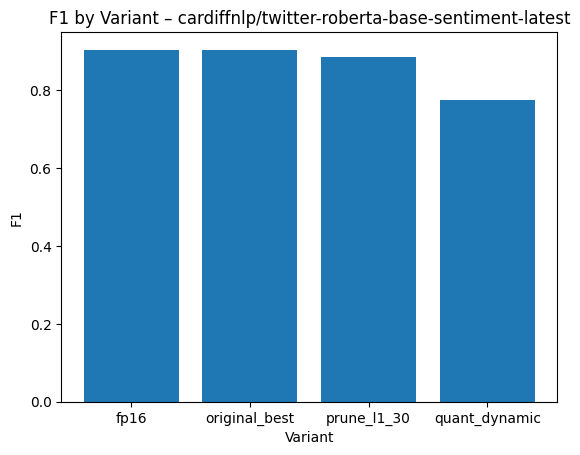

In [ ]:
# ========================== Compression + Comparison via manifest ==========================


# -------- Load manifest --------
PROJECT_ROOT = str(p('Colab Notebooks'))   # <-- adjust if needed
RESULTS_ROOT = os.path.join(PROJECT_ROOT, "results")
manifest_path = os.path.join(PROJECT_ROOT, "run_manifest.json")
with open(manifest_path, "r", encoding="utf-8") as f:
    manifest = json.load(f)

BEST_DIR     = manifest["best_dir"]
MODEL_ALIAS  = manifest["model_alias"]
TEXT_COL     = manifest["text_col"]
LABEL_COL    = manifest["label_col"]
CLASS_NAMES  = manifest.get("class_names", ["Negative","Neutral","Positive"])
ID2LABEL     = {i: c for i, c in enumerate(CLASS_NAMES)}
LABEL2ID     = {c: i for i, c in enumerate(CLASS_NAMES)}

print("Loaded manifest:", manifest_path)
print("BEST_DIR:", BEST_DIR)

# -------- Load base model/tokenizer --------
base_model = AutoModelForSequenceClassification.from_pretrained(
    BEST_DIR, num_labels=len(CLASS_NAMES), id2label=ID2LABEL, label2id=LABEL2ID
)
tokenizer = AutoTokenizer.from_pretrained(BEST_DIR)

# -------- Make compressed variants --------
compressed_root = os.path.join(RESULTS_ROOT, "compressed")
os.makedirs(compressed_root, exist_ok=True)

# (a) Dynamic quantization (in-memory; not saved)
q_model = compress_model(base_model, method="quant_dynamic")
print("[quant_dynamic] in-memory only (not saved)")

# (b) L1 pruning (30%) — saved
p_model = AutoModelForSequenceClassification.from_pretrained(
    BEST_DIR, num_labels=len(CLASS_NAMES), id2label=ID2LABEL, label2id=LABEL2ID
)
p_model = compress_model(p_model, method="prune_l1", amount=0.30)
p_dir   = os.path.join(compressed_root, "prune_l1_30")
save_model_and_tokenizer(p_model, tokenizer, p_dir, extra={"method": "prune_l1", "amount": 0.30})

# (c) FP16 cast — saved
fp16_model = AutoModelForSequenceClassification.from_pretrained(
    BEST_DIR, num_labels=len(CLASS_NAMES), id2label=ID2LABEL, label2id=LABEL2ID
)
fp16_model = compress_model(fp16_model, method="fp16")
fp16_dir   = os.path.join(compressed_root, "fp16")
save_model_and_tokenizer(fp16_model, tokenizer, fp16_dir, extra={"method": "fp16"})

print("Saved compressed under:", compressed_root)
print(" - prune:", p_dir)
print(" - fp16 :", fp16_dir)

def _is_dynamic_quantized(model):
    import torch
    for m in model.modules():
        # detect qint weights
        w = getattr(m, "weight", None)
        if w is not None and hasattr(w, "dtype") and str(w.dtype).startswith("torch.q"):
            return True
        # detect nn.quantized.Linear if present
        try:
            import torch.nn.quantized as nnq
            if isinstance(m, nnq.Linear):
                return True
        except Exception:
            pass
    return False

def _eval_variant(model, name: str):
    force_dev = "cpu" if _is_dynamic_quantized(model) else None
    return evaluate_model_compression(
        model_or_path=model,
        tokenizer_or_path=tokenizer,
        test_df=test_df,
        label_col=LABEL_COL,
        text_col=TEXT_COL,
        batch_size=16,
        device=force_dev,
        run_name=f"TEST::{MODEL_ALIAS}::{name}"
    )

orig_metrics  = _eval_variant(base_model,  "original_best")
quant_metrics = _eval_variant(q_model,     "quant_dynamic")
prune_metrics = _eval_variant(p_model,     "prune_l1_30")
fp16_metrics  = _eval_variant(fp16_model,  "fp16")

# -------- Summarize table + quick F1 bar --------
rows = []
def _row(name, m):
    rows.append({
        "variant": name,
        "accuracy": m.get("accuracy"),
        "precision": m.get("precision"),
        "recall": m.get("recall"),
        "f1": m.get("f1"),
        "macro_auc": m.get("macro_auc"),
    })

for name, m in [
    ("original_best", orig_metrics),
    ("quant_dynamic", quant_metrics),
    ("prune_l1_30",  prune_metrics),
    ("fp16",         fp16_metrics),
]:
    _row(name, m)

cmp_df = pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)
display(cmp_df)

plt.figure()
plt.bar(cmp_df["variant"], cmp_df["f1"])
plt.title(f"F1 by Variant – {MODEL_ALIAS}")
plt.xlabel("Variant"); plt.ylabel("F1"); plt.show()

#Model B

##Model A- Train

In [ ]:
# -------- End-to-end helper: run study, save the global best --------
def run_optuna_and_save_best(
    model_alias: str,
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    label_col: str = "Sentiment",
    n_trials: int = 10,
    use_wandb: bool = True,
    results_root: str = str(out_path('results')),
    study_name: str = "sentiment_study",
):
    """
    Build datasets, run Optuna on train/val only, and save the best model+tokenizer+HP.
    Returns path to the saved best model directory and the best HPs.
    """
    # Tokenizer & text column
    tokenizer, text_col = build_tokenizer_and_column(model_alias)

    # HF datasets (raw -> HF)
    ds_train, ds_val = make_hf_datasets(df_train, df_val, label_col=label_col)

    # Optuna study
    direction = "maximize"
    study = optuna.create_study(direction=direction, study_name=study_name)
    study.optimize(
        lambda tr: objective_train_val_only(
            tr, model_alias, ds_train, ds_val, tokenizer, text_col,
            use_wandb=use_wandb, results_root=results_root
        ),
        n_trials=n_trials
    )

    best_params = study.best_trial.params
    # Rebuild best run dir: we saved per-trial best under results_root/trial_X/best
    # Find which trial had best value:
    best_trial_num = study.best_trial.number
    best_dir = f"{results_root}/trial_{best_trial_num}/best"

    # Save params for reproducibility
    os.makedirs(best_dir, exist_ok=True)
    with open(os.path.join(best_dir, "best_params.json"), "w", encoding="utf-8") as f:
        json.dump(best_params, f, indent=2)

    return best_dir, best_params, tokenizer, text_col

In [ ]:
# --- Mount Drive if you're on Colab (optional but recommended) ---

drive.mount(str(p('drive')), force_remount=True)


# ====== PATHS you control ======
PROJECT_ROOT = str(p('Colab Notebooks'))   # <-- change if needed
RESULTS_ROOT = os.path.join(PROJECT_ROOT, "results")
os.makedirs(RESULTS_ROOT, exist_ok=True)

# 1) Load splits (already saved CSVs)
split_dir = os.path.join(PROJECT_ROOT, "split_data")
train_df = pd.read_csv(os.path.join(split_dir, "train_set.csv"))
val_df   = pd.read_csv(os.path.join(split_dir, "validation_set.csv"))
test_df  = pd.read_csv(os.path.join(split_dir, "test_set.csv"))

# 2) Train/Val only (no test here)
MODEL_ALIAS = "distilbert-base-uncased"
best_dir, best_params, tokenizer, text_col = run_optuna_and_save_best(
    model_alias=MODEL_ALIAS,
    df_train=train_df,
    df_val=val_df,
    label_col="Sentiment",
    n_trials=12,
    use_wandb=True,
    results_root=RESULTS_ROOT,
    study_name="sentiment_study_v1"
)

# 3) Save a manifest with everything needed for the TEST phase later
manifest = {
    "project_root": PROJECT_ROOT,
    "results_root": RESULTS_ROOT,
    "model_alias": MODEL_ALIAS,
    "best_dir": best_dir,           # path with best model + tokenizer
    "best_params": best_params,     # Optuna best hyperparams
    "text_col": text_col,           # which text column to tokenize
    "label_col": "Sentiment",
    "class_names": CLASS_NAMES,     # optional, for reproducibility
}
with open(os.path.join(PROJECT_ROOT, "run_manifest.json"), "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2)

print("Saved manifest at:", os.path.join(PROJECT_ROOT, "run_manifest.json"))

Mounted at /content/drive


[I 2025-08-21 13:42:16,099] A new study created in memory with name: sentiment_study_v1


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 0] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/1ljavwvh


Step,Training Loss
1801,0.693200
3602,0.363000
5403,0.262900
7204,0.205100
9005,0.171600


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▅█▃▁▁


[I 2025-08-21 13:51:53,997] Trial 0 finished with value: 0.8879794006811936 and parameters: {'learning_rate': 1.3805536220587517e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.0006626134499308592, 'warmup_ratio': 0.1}. Best is trial 0 with value: 0.8879794006811936.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 1] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/nrc4ydpa


Step,Training Loss
1801,0.614000
3602,0.305200
5403,0.205000
7204,0.142100
9005,0.099100


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▇█▁▁▁


[I 2025-08-21 14:01:34,980] Trial 1 finished with value: 0.8891218182198933 and parameters: {'learning_rate': 3.299954957529765e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.00048284402118948963, 'warmup_ratio': 0.1}. Best is trial 1 with value: 0.8891218182198933.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 2] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/h33nzv0c


Step,Training Loss
901,0.621400
1802,0.320000
2703,0.215700
3604,0.161800
4505,0.121400


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▅█▅▂▁


[I 2025-08-21 14:09:19,944] Trial 2 finished with value: 0.8933153281144556 and parameters: {'learning_rate': 2.4542745776594264e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.00031798662384521456, 'warmup_ratio': 0.05}. Best is trial 2 with value: 0.8933153281144556.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 3] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/zp4geqct


Step,Training Loss
901,0.675900
1802,0.337800
2703,0.224300
3604,0.164200
4505,0.125500


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▅█▄▃▁


[I 2025-08-21 14:17:22,035] Trial 3 finished with value: 0.8922470800485908 and parameters: {'learning_rate': 2.3676338644674868e-05, 'per_device_train_batch_size': 32, 'weight_decay': 1.675320406540573e-05, 'warmup_ratio': 0.1}. Best is trial 2 with value: 0.8933153281144556.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 4] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/gxby0t0v


Step,Training Loss
1801,0.646000
3602,0.324300
5403,0.224100
7204,0.166600
9005,0.127200


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,█▇▂▁▁


[I 2025-08-21 14:27:03,425] Trial 4 finished with value: 0.8914886675465837 and parameters: {'learning_rate': 2.1706250448602736e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.0007125931181109681, 'warmup_ratio': 0.1}. Best is trial 2 with value: 0.8933153281144556.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 5] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/pas6jak6


Step,Training Loss
1801,0.592000
3602,0.305300
5403,0.211200
7204,0.155100
9005,0.117000


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▇█▁▁▁


[I 2025-08-21 14:36:56,023] Trial 5 finished with value: 0.8892917818149421 and parameters: {'learning_rate': 2.433677672632366e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.0007575305011737766, 'warmup_ratio': 0.05}. Best is trial 2 with value: 0.8933153281144556.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 6] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/r817hxx8


Step,Training Loss
901,0.615100
1802,0.291500
2703,0.182200
3604,0.119800
4505,0.080100


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▃█▃▁▁


[I 2025-08-21 14:45:04,186] Trial 6 finished with value: 0.884636774723694 and parameters: {'learning_rate': 4.667755902141227e-05, 'per_device_train_batch_size': 32, 'weight_decay': 9.351543093890286e-05, 'warmup_ratio': 0.1}. Best is trial 2 with value: 0.8933153281144556.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 7] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/f3va52v9


Step,Training Loss
1801,0.599300
3602,0.295300
5403,0.192100
7204,0.128600
9005,0.081600


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▄█▁▁▁


[I 2025-08-21 14:55:04,023] Trial 7 finished with value: 0.8876259904986172 and parameters: {'learning_rate': 4.744600587917802e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.0006655807755363097, 'warmup_ratio': 0.1}. Best is trial 2 with value: 0.8933153281144556.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 8] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/bansew86


Step,Training Loss
901,0.761900
1802,0.421300
2703,0.316200
3604,0.257300
4505,0.220300


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▄▅▇█▁


[I 2025-08-21 15:03:07,627] Trial 8 finished with value: 0.8747893254259161 and parameters: {'learning_rate': 1.1519610473438849e-05, 'per_device_train_batch_size': 32, 'weight_decay': 3.024135768360552e-05, 'warmup_ratio': 0.1}. Best is trial 2 with value: 0.8933153281144556.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 9] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/7v45iqpc


Step,Training Loss
1801,0.603900
3602,0.315900
5403,0.224300
7204,0.168700
9005,0.128500


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▇█▃▁▁


[I 2025-08-21 15:13:03,694] Trial 9 finished with value: 0.886338355897239 and parameters: {'learning_rate': 2.042661235076002e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.0003334480210284372, 'warmup_ratio': 0.05}. Best is trial 2 with value: 0.8933153281144556.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 10] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/2kq8v7fi


Step,Training Loss
901,0.668500
1802,0.364100
2703,0.263100
3604,0.207700
4505,0.171200


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▅▇█▅▁


[I 2025-08-21 15:21:04,240] Trial 10 finished with value: 0.881436981165034 and parameters: {'learning_rate': 1.599341312484151e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.00015379416629136104, 'warmup_ratio': 0.05}. Best is trial 2 with value: 0.8933153281144556.


Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/4115 [00:00<?, ? examples/s]

/tmp/ipython-input-1691485482.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[Trial 11] W&B: https://wandb.ai/ronitauber2-tel-aviv-university/nlp-sentiment-optuna/runs/1gmhlt92


Step,Training Loss
901,0.599200
1802,0.299600
2703,0.195900


Step,Training Loss
901,0.599200
1802,0.299600
2703,0.195900
3604,0.140400
4505,0.103700


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▃▅▆███
train/global_step,▁▃▅▆███
train/grad_norm,▄█▂▂▁


[I 2025-08-21 15:29:07,492] Trial 11 finished with value: 0.8888350721634368 and parameters: {'learning_rate': 3.0955866597747376e-05, 'per_device_train_batch_size': 32, 'weight_decay': 1.859118920350827e-05, 'warmup_ratio': 0.05}. Best is trial 2 with value: 0.8933153281144556.


Saved manifest at: /content/drive/My Drive/Colab Notebooks/run_manifest.json


In [ ]:
# --- Mount Drive if you're on Colab (optional but recommended) ---
from google.colab import drive
drive.mount(str(p('drive')), force_remount=True)


# ====== PATHS you control ======
PROJECT_ROOT = str(p('Colab Notebooks'))   # <-- change if needed
RESULTS_ROOT = os.path.join(PROJECT_ROOT, "results")
os.makedirs(RESULTS_ROOT, exist_ok=True)

# 1) Load splits (already saved CSVs)
split_dir = os.path.join(PROJECT_ROOT, "split_data")
train_df = pd.read_csv(os.path.join(split_dir, "train_set.csv"))
val_df   = pd.read_csv(os.path.join(split_dir, "validation_set.csv"))
test_df  = pd.read_csv(os.path.join(split_dir, "test_set.csv"))

Mounted at /content/drive


In [ ]:
# 5) Evaluate original best model on TEST
# Initialize a new W&B run

# Initialize a new W&B run
wandb.init(project="nlp-sentiment-optuna", name="distilbert-base-uncased")

orig_metrics = evaluate_model_on_test(
    model_or_path=BEST_DIR,
    tokenizer_or_path=BEST_DIR,
    test_df=test_df,
    label_col=LABEL_COL,
    text_col=TEXT_COL,
    max_length=128,
    use_wandb=True,
    run_name="TEST::original_best",
)

print("Original model (best_dir) metrics:", orig_metrics)

wandb.finish()

Map:   0%|          | 0/8233 [00:00<?, ? examples/s]

/tmp/ipython-input-3910680563.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  pred_trainer = Trainer(


Original model (best_dir) metrics: {'accuracy': 0.9076885703874651, 'precision': 0.9004758450353495, 'recall': 0.89573812549713, 'f1': 0.8979950447900956, 'macro_auc': np.float64(0.9755745412832968)}


test/loss,▁
test/model_preparation_time,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
train/global_step,▁▁
Test/Accuracy,0.90769
Test/F1,0.898
Test/MacroAUC,0.97557
Test/Precision,0.90048
Test/Recall,0.89574


## Model B - compression

In [ ]:
# ---- Normalize labels in test_df to consistent int ids ----


_label2id = {c: i for i, c in enumerate(CLASS_NAMES)}  # ["Negative","Neutral","Positive"] -> {..}

def _to_int_label(v):
    # already int?
    if isinstance(v, (int, np.integer)):
        return int(v)
    # numeric as string?
    if isinstance(v, str) and v.isdigit():
        return int(v)
    # class name as string?
    if isinstance(v, str) and v in _label2id:
        return _label2id[v]
    raise ValueError(f"Unknown label value in `{LABEL_COL}`: {v!r}")

test_df[LABEL_COL] = test_df[LABEL_COL].apply(_to_int_label).astype(int)

print("Labels normalized. Unique values:", sorted(test_df[LABEL_COL].unique()))

Labels normalized. Unique values: [np.int64(0), np.int64(1), np.int64(2)]


Loaded manifest: /content/drive/My Drive/Colab Notebooks/run_manifest.json
BEST_DIR: /content/drive/My Drive/Colab Notebooks/results/trial_2/best
[quant_dynamic] in-memory only (not saved)
Saved compressed under: /content/drive/My Drive/Colab Notebooks/results/compressed
 - prune: /content/drive/My Drive/Colab Notebooks/results/compressed/prune_l1_30
 - fp16 : /content/drive/My Drive/Colab Notebooks/results/compressed/fp16


Evaluating TEST::distilbert-base-uncased::original_best: 100%|██████████| 515/515 [00:15<00:00, 32.84it/s]



[TEST::distilbert-base-uncased::original_best]
Accuracy : 0.9039
Precision: 0.9013
Recall   : 0.8889
F1-score : 0.8945
Macro AUC: 0.9723


Evaluating TEST::distilbert-base-uncased::quant_dynamic: 100%|██████████| 515/515 [02:14<00:00,  3.82it/s]



[TEST::distilbert-base-uncased::quant_dynamic]
Accuracy : 0.8904
Precision: 0.8838
Recall   : 0.8784
F1-score : 0.8810
Macro AUC: 0.9661


Evaluating TEST::distilbert-base-uncased::prune_l1_30: 100%|██████████| 515/515 [00:15<00:00, 33.56it/s]



[TEST::distilbert-base-uncased::prune_l1_30]
Accuracy : 0.8975
Precision: 0.8948
Recall   : 0.8845
F1-score : 0.8892
Macro AUC: 0.9715


Evaluating TEST::distilbert-base-uncased::fp16: 100%|██████████| 515/515 [00:03<00:00, 131.60it/s]



[TEST::distilbert-base-uncased::fp16]
Accuracy : 0.9039
Precision: 0.9013
Recall   : 0.8889
F1-score : 0.8945
Macro AUC: 0.9723


,variant,accuracy,precision,recall,f1,macro_auc
0,original_best,0.903923,0.901270,0.888886,0.894495,0.972322
1,fp16,0.903923,0.901270,0.888886,0.894495,0.972311
2,prune_l1_30,0.897486,0.894825,0.884471,0.889173,0.971502
3,quant_dynamic,0.890441,0.883763,0.878418,0.880991,0.966146


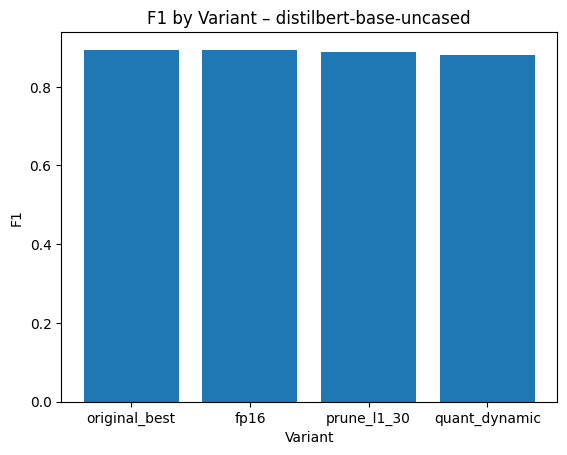

In [ ]:
# -------- Load manifest --------
PROJECT_ROOT = str(p('Colab Notebooks'))   # <-- adjust if needed
RESULTS_ROOT = os.path.join(PROJECT_ROOT, "results")
manifest_path = os.path.join(PROJECT_ROOT, "run_manifest.json")
with open(manifest_path, "r", encoding="utf-8") as f:
    manifest = json.load(f)

BEST_DIR     = manifest["best_dir"]
MODEL_ALIAS  = manifest["model_alias"]
TEXT_COL     = manifest["text_col"]
LABEL_COL    = manifest["label_col"]
CLASS_NAMES  = manifest.get("class_names", ["Negative","Neutral","Positive"])
ID2LABEL     = {i: c for i, c in enumerate(CLASS_NAMES)}
LABEL2ID     = {c: i for i, c in enumerate(CLASS_NAMES)}

print("Loaded manifest:", manifest_path)
print("BEST_DIR:", BEST_DIR)

# -------- Load base model/tokenizer --------
base_model = AutoModelForSequenceClassification.from_pretrained(
    BEST_DIR, num_labels=len(CLASS_NAMES), id2label=ID2LABEL, label2id=LABEL2ID
)
tokenizer = AutoTokenizer.from_pretrained(BEST_DIR)

# -------- Make compressed variants --------
compressed_root = os.path.join(RESULTS_ROOT, "compressed")
os.makedirs(compressed_root, exist_ok=True)

# (a) Dynamic quantization (in-memory; not saved)
q_model = compress_model(base_model, method="quant_dynamic")
print("[quant_dynamic] in-memory only (not saved)")

# (b) L1 pruning (30%) — saved
p_model = AutoModelForSequenceClassification.from_pretrained(
    BEST_DIR, num_labels=len(CLASS_NAMES), id2label=ID2LABEL, label2id=LABEL2ID
)
p_model = compress_model(p_model, method="prune_l1", amount=0.30)
p_dir   = os.path.join(compressed_root, "prune_l1_30")
save_model_and_tokenizer(p_model, tokenizer, p_dir, extra={"method": "prune_l1", "amount": 0.30})

# (c) FP16 cast — saved
fp16_model = AutoModelForSequenceClassification.from_pretrained(
    BEST_DIR, num_labels=len(CLASS_NAMES), id2label=ID2LABEL, label2id=LABEL2ID
)
fp16_model = compress_model(fp16_model, method="fp16")
fp16_dir   = os.path.join(compressed_root, "fp16")
save_model_and_tokenizer(fp16_model, tokenizer, fp16_dir, extra={"method": "fp16"})

print("Saved compressed under:", compressed_root)
print(" - prune:", p_dir)
print(" - fp16 :", fp16_dir)

def _is_dynamic_quantized(model):
    import torch
    for m in model.modules():
        # detect qint weights
        w = getattr(m, "weight", None)
        if w is not None and hasattr(w, "dtype") and str(w.dtype).startswith("torch.q"):
            return True
        # detect nn.quantized.Linear if present
        try:
            import torch.nn.quantized as nnq
            if isinstance(m, nnq.Linear):
                return True
        except Exception:
            pass
    return False

def _eval_variant(model, name: str):
    force_dev = "cpu" if _is_dynamic_quantized(model) else None
    return evaluate_model_compression(
        model_or_path=model,
        tokenizer_or_path=tokenizer,
        test_df=test_df,
        label_col=LABEL_COL,
        text_col=TEXT_COL,
        batch_size=16,
        device=force_dev,
        run_name=f"TEST::{MODEL_ALIAS}::{name}"
    )

orig_metrics  = _eval_variant(base_model,  "original_best")
quant_metrics = _eval_variant(q_model,     "quant_dynamic")
prune_metrics = _eval_variant(p_model,     "prune_l1_30")
fp16_metrics  = _eval_variant(fp16_model,  "fp16")

# -------- Summarize table + quick F1 bar --------
rows = []
def _row(name, m):
    rows.append({
        "variant": name,
        "accuracy": m.get("accuracy"),
        "precision": m.get("precision"),
        "recall": m.get("recall"),
        "f1": m.get("f1"),
        "macro_auc": m.get("macro_auc"),
    })

for name, m in [
    ("original_best", orig_metrics),
    ("quant_dynamic", quant_metrics),
    ("prune_l1_30",  prune_metrics),
    ("fp16",         fp16_metrics),
]:
    _row(name, m)

cmp_df = pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)
display(cmp_df)

plt.figure()
plt.bar(cmp_df["variant"], cmp_df["f1"])
plt.title(f"F1 by Variant – {MODEL_ALIAS}")
plt.xlabel("Variant"); plt.ylabel("F1"); plt.show()